In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
from cloudy_fit_lib import *
from scipy.interpolate import RegularGridInterpolator
import pickle
import corner
from scipy import integrate, interpolate
import emcee

In [2]:
plt.style.use('/Users/thepoetoftwilight/Documents/Astro/Code/PG1522+101/science.mplstyle')

In [3]:
rootdir = '/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/cloudy_grids/'

In [4]:
savedir = '/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z=1.27767214/cloudy_fits/'

Obtain the UVB grid from FG20

In [5]:
fg20_z_grid, fg20_wav_grid, fg20_J_nu_grid = read_uvb('', 'fg20_galaxy.ascii')

Fetch the SED at $z=1$

In [6]:
z_test = 1

In [7]:
fg20_J_nu_test = fetch_sed(z_test, fg20_z_grid, fg20_J_nu_grid)

Specify $N_{\mathrm{HI}}$ grid points and get corresponding filenames

In [8]:
logN_HI_min = 12
logN_HI_max = 17
logN_HI_step = 0.25

logN_HI_arr = np.arange(logN_HI_min, logN_HI_max+logN_HI_step, logN_HI_step)

In [9]:
file_list = create_grid_file_list(logN_HI_arr)

Specify grid points for densities and metallicities

In [10]:
log_hdens_min = -5
log_hdens_max = 1
log_hdens_step = 0.25

log_hdens_arr = np.arange(log_hdens_min, log_hdens_max+log_hdens_step, log_hdens_step)
logU_arr = np.log10(calc_U(fg20_wav_grid, fg20_J_nu_test, 10**log_hdens_arr))

In [11]:
log_metals_min = -3
log_metals_max = 1
log_metals_step = 0.25

log_metals_arr = np.arange(log_metals_min, log_metals_max+log_metals_step, log_metals_step)

Load the final grid

In [12]:
pkl_file = open(rootdir+'final_grid.pkl', 'rb')
species_logN_samples = pickle.load(pkl_file)
pkl_file.close()

Interpolate this grid

In [13]:
species_logN_interp = {}

for s in list(species_logN_samples.keys()):
    
    species_logN_samples[s][species_logN_samples[s]==-np.inf] = -99
    
    species_logN_interp[s] = RegularGridInterpolator((logN_HI_arr, log_hdens_arr, log_metals_arr), 
                                                     species_logN_samples[s])

# c1

## Column density ratios

Enter measurements for species

In [14]:
logN_dict = {'HI':'14.09, -0.06, +0.06',
            'HeI':'<13.1',
            'CII':'<13.4',
            'CIII':'13.0, -0.1, +0.1',
            'CIV':'13.66, -0.01, +0.01',
            'NII':'<13.4',
            'NIII':'<13.0',
            'NIV':'13.1, -0.1, +0.1',
            'OIII':'13.83, -0.08, +0.08',
            'OIV':'14.34, -0.04, +0.04',
            'OV':'>14.3', #(14.6, -0.2, +0.3)',
            'OVI':'>14.5', #(14.8, -0.1, +0.2)',
            'NeV':'14.13, -0.05, +0.05',
            'NeVI':'14.18, -0.04, +0.04',
            'NeVIII':'<14.0',
            'MgX':'<13.6',
            'AlII':'<11.0',
            'AlIII':'<11.4',
            'SiII':'<14.0',
            'SiIII':'<12.2',
            'SiIV':'<12.0',
            'SIV':'<12.9',
            'SV':'<12.9',
            'SVI':'<13.5',
            'FeII':'<11.8',}

Get column density ratios

In [15]:
gen_logN_ratio_str(logN_dict['NeVI'], logN_dict['OIV'])

'-0.16, -0.06, 0.06'

In [16]:
logN_ratio_dict = {'CIII/CIV': '-0.66, -0.10, 0.10',
                   'OV/OIV': '>-0.04, 0.33',
                   'OVI/OIV': '>0.16, 0.33',
                   'NeV/OIV': '-0.21, -0.06, 0.06',
                   'NeVI/OIV': '-0.16, -0.06, 0.06'
                   }

Generate predicted column density ratios

(-5.0, 2.0)

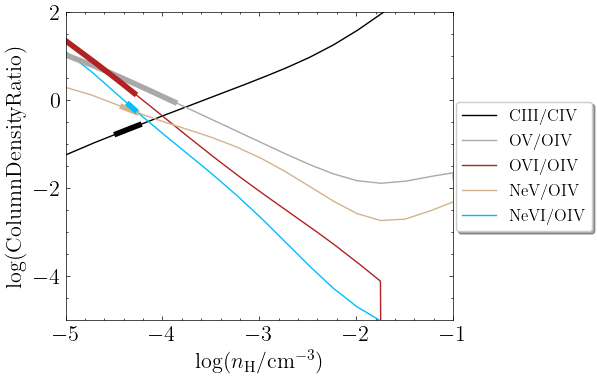

In [17]:
fig, ax = plt.subplots(1, figsize=(5,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict, log_metals_ref=-1.0)

ax.set_xlim(-5, -1)
ax.set_ylim(-5, 2)

## Single phase solution

In [18]:
def lambda_log_prior(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O, N_O = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O, 'N':N_O}])
    
    return log_prior(params_full)

In [19]:
def lambda_log_likelihood(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O, N_O = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O, 'N':N_O}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood(params_full, logN_dict, species_logN_interp)    

In [20]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood(params, logN_dict, species_logN_interp)

In [21]:
logN_dict = {#'HI':'14.09, -0.06, +0.06',
            'HeI':'<13.1',
            'CII':'<13.4',
            'CIII':'13.0, -0.1, +0.1',
            'CIV':'13.66, -0.01, +0.01',
            'NII':'<13.4',
            'NIII':'<13.0',
            'NIV':'13.1, -0.1, +0.1',
            #'OIII':'13.83, -0.08, +0.08',
            'OIV':'14.34, -0.04, +0.04',
            'OV':'>14.3', #(14.6, -0.2, +0.3)
            'OVI':'>14.5', #(14.8, -0.1, +0.2)
            #'NeV':'14.13, -0.05, +0.05',
            #'NeVI':'14.18, -0.04, +0.04',
            'NeVIII':'<14.0',
            #'MgX':'<13.6',
            #'AlII':'<11.0',
            #'AlIII':'<11.4',
            'SiII':'<14.0',
            'SiIII':'<12.2',
            'SiIV':'<12.0',
            'SIV':'<12.9',
            'SV':'<12.9',
            'SVI':'<13.5',}
            #'FeII':'<11.8',}

In [22]:
logN_HI_test = 14.09
log_hdens_test = -4.3
log_metals_test = -0.2
C_O_test = -0.15
N_O_test = -0.5

In [23]:
logN_species_test = np.array(predict_col_dens(logN_dict, logN_HI_test, log_hdens_test, log_metals_test, species_logN_interp, {'C':C_O_test, 'N':N_O_test}))

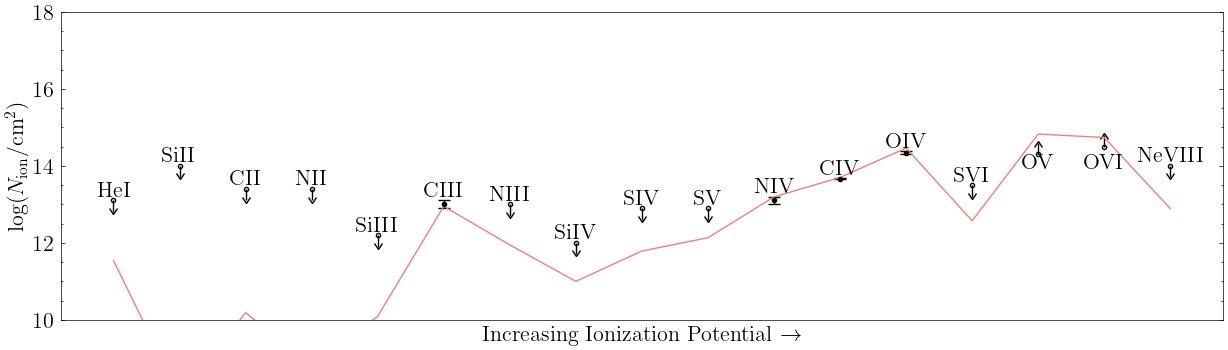

In [24]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [25]:
pos = np.array([log_hdens_test, log_metals_test, C_O_test, N_O_test]) + 1e-7 * np.random.randn(200, 4)
nwalkers, ndim = pos.shape

In [26]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [27]:
sampler.run_mcmc(pos, 500, progress=True);

100%|█████████████████████████████████████████| 500/500 [03:22<00:00,  2.47it/s]


In [28]:
flat_samples = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
                                columns=['log_hdens', 'log_metals', 'C_O', 'N_O'])
flat_samples.to_csv(savedir+'one_phase_c1.csv', index=False)

#flat_samples = pd.read_csv(savedir+'one_phase_c1.csv')

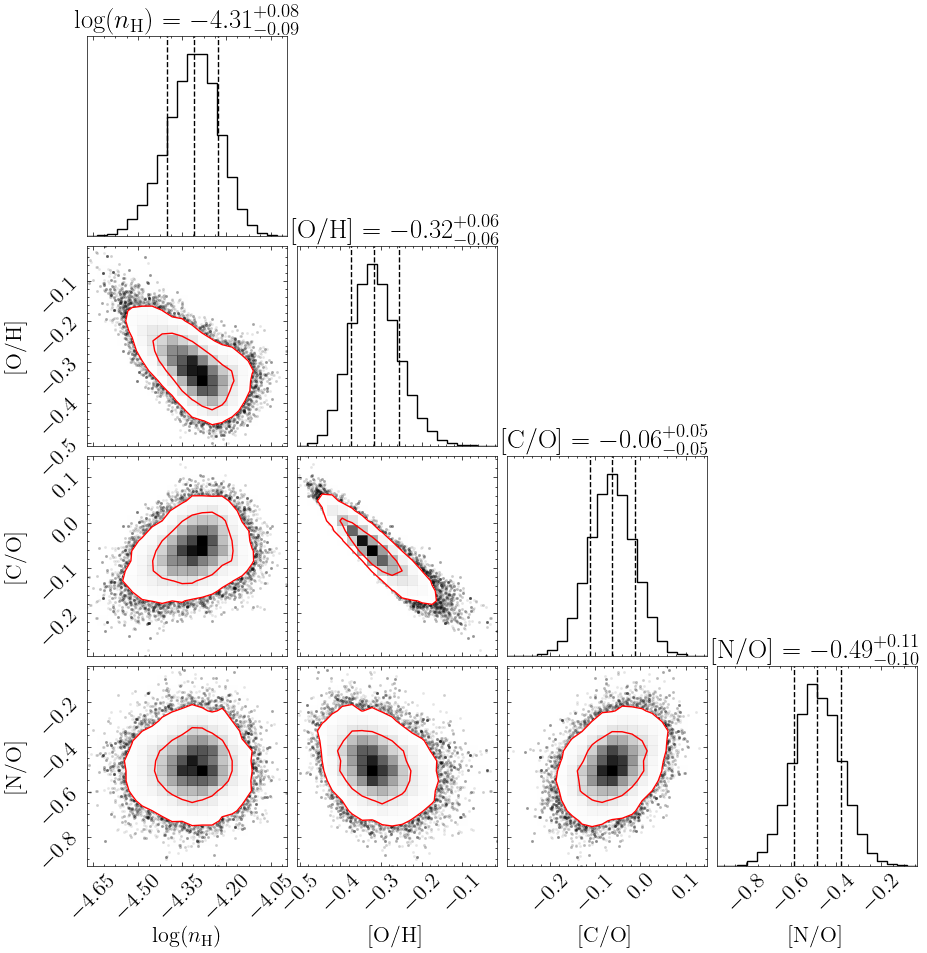

In [29]:
fig = corner.corner(
    flat_samples, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$', r'$[\mathrm{O/H}]$', r'$[\mathrm{C/O}]$', r'$[\mathrm{N/O}]$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

Now plot the best models

In [30]:
logN_dict = {#'HI':'14.09, -0.06, +0.06',
            #'HeI':'<13.1',
            #'CII':'<13.4',
            'CIII':'13.0, -0.1, +0.1',
            'CIV':'13.66, -0.01, +0.01',
            #'NII':'<13.4',
            #'NIII':'<13.0',
            'NIV':'13.1, -0.1, +0.1',
            'OIII':'13.83, -0.08, +0.08',
            'OIV':'14.34, -0.04, +0.04',
            'OV':'>14.3', #(14.6, -0.2, +0.3)
            'OVI':'>14.5', #(14.8, -0.1, +0.2)
            'NeV':'14.13, -0.05, +0.05',
            'NeVI':'14.18, -0.04, +0.04',
            'NeVIII':'<14.0',
            #'MgX':'<13.6',
            #'AlII':'<11.0',
            #'AlIII':'<11.4',
            #'SiII':'<14.0',
            #'SiIII':'<12.2',
            #'SiIV':'<12.0',
            'SIV':'<12.9',
            'SV':'<12.9',
            'SVI':'<13.5',}
            #'FeII':'<11.8',}

In [31]:
b_dict = {'HI':'24, -3, +3',
          'CIII':'10.6, -0.2, +0.2',
          'CIV':'10.6, -0.2, +0.2',
          'NIV':'12, -4, +5',
          'OIII':'14, -1, +1',
          'OIV':'14, -1, +1',
          'OV':'14, -1, +1',
          'OVI':'14, -1, +1'}

In [32]:
z_sys = 1.27767214

In [33]:
import matplotlib.lines as mlines

In [34]:
logN_species_best = predict_col_dens(logN_dict, logN_HI_test, np.median(flat_samples['log_hdens']), 
                                        np.median(flat_samples['log_metals']), 
                                        species_logN_interp, {'C':np.median(flat_samples['C_O']), 
                                                              'N':np.median(flat_samples['N_O'])})

In [35]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_best)

In [36]:
logN_res_up = {k:'<2.0' for k in list(logN_res_dict.keys())}

#logN_res_up['SiII'] = '<0.75'
logN_res_up['SIV'] = '<0.75'
logN_res_up['SV'] = '<0.75'
logN_res_up['SVI'] = '<0.75'

logN_res_up['OIII'] = '<0.75'
logN_res_up['NeVIII'] = '<0.75'

In [37]:
# Model curves for each step
logN_species_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples['log_hdens'], flat_samples['log_metals'], 
                                                 species_logN_interp, {'C':flat_samples['C_O'], 'N':flat_samples['N_O']})

In [38]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_lo = np.percentile(flat_samples['log_hdens'], 100*(1-cdf_1sig))
log_hdens_hi = np.percentile(flat_samples['log_hdens'], 100*cdf_1sig)

log_metals_lo = np.percentile(flat_samples['log_metals'], 100*(1-cdf_1sig))
log_metals_hi = np.percentile(flat_samples['log_metals'], 100*cdf_1sig)

C_O_lo = np.percentile(flat_samples['C_O'], 100*(1-cdf_1sig))
C_O_hi = np.percentile(flat_samples['C_O'], 100*cdf_1sig)

N_O_lo = np.percentile(flat_samples['N_O'], 100*(1-cdf_1sig))
N_O_hi = np.percentile(flat_samples['N_O'], 100*cdf_1sig)

for i in range(len(flat_samples)):
    log_hdens = flat_samples['log_hdens'][i]
    log_metals = flat_samples['log_metals'][i]
    C_O = flat_samples['C_O'][i]
    N_O = flat_samples['N_O'][i]
    
    if log_hdens_lo<log_hdens<log_hdens_hi and log_metals_lo<log_metals<log_metals_hi and C_O_lo<C_O<C_O_hi and N_O_lo<N_O<N_O_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

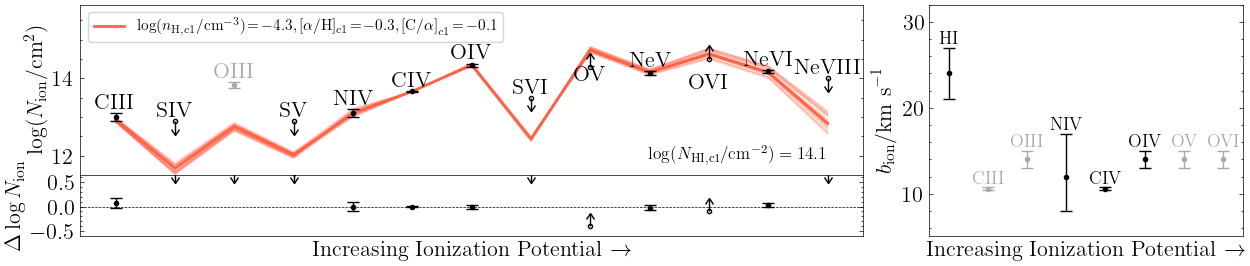

In [39]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

for idx in plot_idx:
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)
    
plot_column_densities_obs(logN_dict, fig, axd['upper left'], gray_out=['OIII'], c_dy=1.7)

axd['upper left'].set_ylim(11.5,15.9)

axd['upper left'].text(len(logN_dict)-1, 11.9, r'$\log(N_\mathrm{HI, c1}/\mathrm{cm}^{-2}) = 14.1$', fontsize=12.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8,
                             label=r'$\log(n_\mathrm{H, c1}/\mathrm{cm}^{-3}) \!=\! -4.3, \mathrm{[\alpha/H]_{c1}} \!=\! -0.3, \mathrm{[C/\alpha]}_{c1}\!=\!-0.1$'))

axd['upper left'].legend(handles=handles, loc='upper left', fontsize=11)

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'],
                          label_ions=False, dy=.15, c_dy=1.7)

plot_column_densities_obs(logN_res_up, fig, axd['lower left'], 
                          label_ions=False, dy=.15, c_dy=1.7)

axd['lower left'].set_ylim(-.6,.65)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_linewidth_obs(b_dict, fig, axd['right'], fs=13, gray_out=['CIII', 'OIII', 'OV', 'OVI'])
axd['right'].set_xlim(-0.5,len(b_dict)-1+.5)
axd['right'].set_ylim(5.1,32)

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

Get cloud sizes

In [40]:
l = get_cloud_size(logN_HI_test, flat_samples['log_hdens'], species_logN_interp, flat_samples['log_metals'])

Text(0, 0.5, 'Counts')

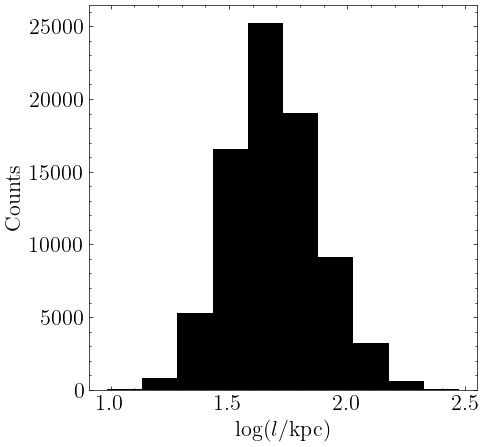

In [41]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l), bins=10)

ax.set_xlabel(r'$\log(l/ \mathrm{kpc})$')
ax.set_ylabel('Counts')

In [42]:
get_quantiles(np.log10(l))

1.68 -0.18 0.2


In [43]:
np.percentile(np.log10(l), 100*cdf_3sig)

2.301452164376731

## Two-phase solution

In [14]:
def lambda_log_prior_two_phase(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O_p1, N_O_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, N_O_p2 = params
    
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C': C_O_p1, 'N': N_O_p1},
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {'C': C_O_p2, 'N': N_O_p2}])
    
    ll = log_prior_two_phase(params_full, species_logN_interp)
    
    if np.isfinite(ll):
        logN_OIV_p1 = species_logN_interp['O+3']([logN_HI_test, log_hdens_p1, log_metals_p1])[0]
        logN_OIV_p2 = species_logN_interp['O+3']([logN_HI_p2, log_hdens_p2, log_metals_p2])[0]
        
        logN_NIV_p1 = species_logN_interp['N+3']([logN_HI_test, log_hdens_p1, log_metals_p1])[0]+N_O_p1
        logN_NIV_p2 = species_logN_interp['N+3']([logN_HI_p2, log_hdens_p2, log_metals_p2])[0]+N_O_p2
        
        if logN_OIV_p1<logN_OIV_p2 and logN_NIV_p1<logN_NIV_p2:
            return ll
        else:
            return -np.inf
    else:
        return -np.inf

In [15]:
def lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O_p1, N_O_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, N_O_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C': C_O_p1, 'N': N_O_p1},
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {'C': C_O_p2, 'N': N_O_p2}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood_two_phase(params_full, logN_dict, species_logN_interp)    

In [16]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_two_phase(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp)

Fit things

In [226]:
logN_dict = {'HI':'14.09, -0.06, +0.06',
            'HeI':'<13.1',
            'CII':'<13.4',
            'CIII':'12.9, -0.2, +0.1',
            'CIV':'13.65, -0.01, +0.01',
            'NII':'<13.4',
            'NIII':'<13.0',
            'NIV':'13.1, -0.1, +0.1',
            'OIII':'13.81, -0.09, +0.09',
            'OIV':'14.44, -0.04, +0.04',
            'OV':'14.4, -0.1, +0.2',
            'OVI':'<14.64',
            'NeV':'14.17, -0.05, +0.05',
            'NeVI':'<14.22',
            #'NeVIII':'<13.6',
            #'MgX':'<13.6',
            #'AlII':'<11.0',
            #'AlIII':'<11.4',
            'SiII':'<14.0',
            'SiIII':'<12.0',
            'SiIV':'<12.0',
            'SIV':'<12.9',
            'SV':'<12.6',
            'SVI':'<13.2',}
            #'FeII':'<11.8',}

In [227]:
logN_HI_test = 14.09
log_hdens_test_p1 = -3.0
log_metals_test_p1 = 0.1
C_O_test_p1 = -2.0
N_O_test_p1 = -2.0

logN_HI_test_p2 = 13.5
log_hdens_test_p2 = -4.1
log_metals_test_p2 = 0.4
C_O_test_p2 = -0.2
N_O_test_p2 = -0.5

In [228]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, 
                                                 logN_HI_test, 
                                                 log_hdens_test_p1, 
                                                 log_metals_test_p1, 
                                                 species_logN_interp,
                                                 {'C': C_O_test_p1, 'N': N_O_test_p1}))

logN_species_test_p2 = np.array(predict_col_dens(logN_dict, 
                                                 logN_HI_test_p2, 
                                                 log_hdens_test_p2, 
                                                 log_metals_test_p2, 
                                                 species_logN_interp,
                                                 {'C': C_O_test_p2, 'N': N_O_test_p2}))

logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

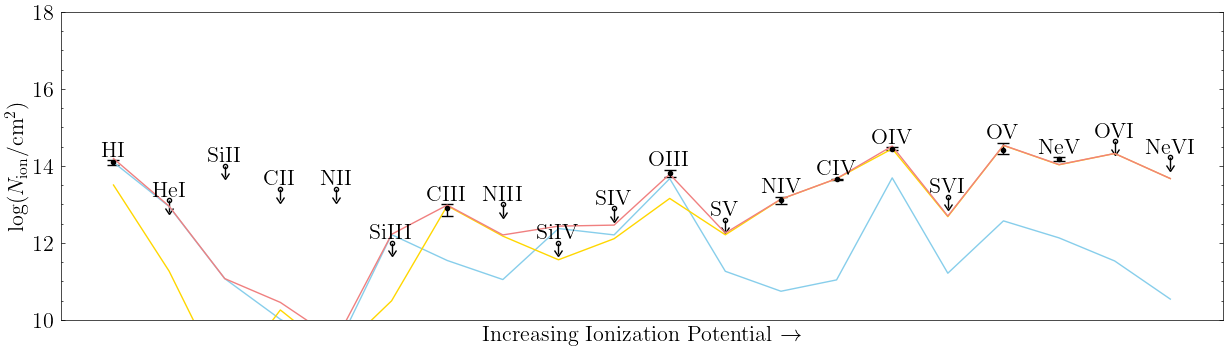

In [28]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='skyblue')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [29]:
log_probability((log_hdens_test_p1, log_metals_test_p1, C_O_test_p1, N_O_test_p1, logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, C_O_test_p2, N_O_test_p2), 
                logN_dict, species_logN_interp)

32.592750142620964

In [30]:
pos = np.array([log_hdens_test_p1, log_metals_test_p1, C_O_test_p1, N_O_test_p1,
                logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, C_O_test_p2, N_O_test_p2]) + 1e-4 * np.random.randn(200, 9)
nwalkers, ndim = pos.shape

In [31]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [32]:
#sampler.run_mcmc(pos, 1000, progress=True);

In [33]:
#flat_samples_two_phase = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens_p1', 'log_metals_p1', 'C_O_p1', 'N_O_p1', 
#                                         'logN_HI_p2', 'log_hdens_p2', 'log_metals_p2', 'C_O_p2', 'N_O_p2'])
#flat_samples_two_phase.to_csv(savedir+'two_phase_c1.csv', index=False)

flat_samples_two_phase = pd.read_csv(savedir+'two_phase_c1.csv')

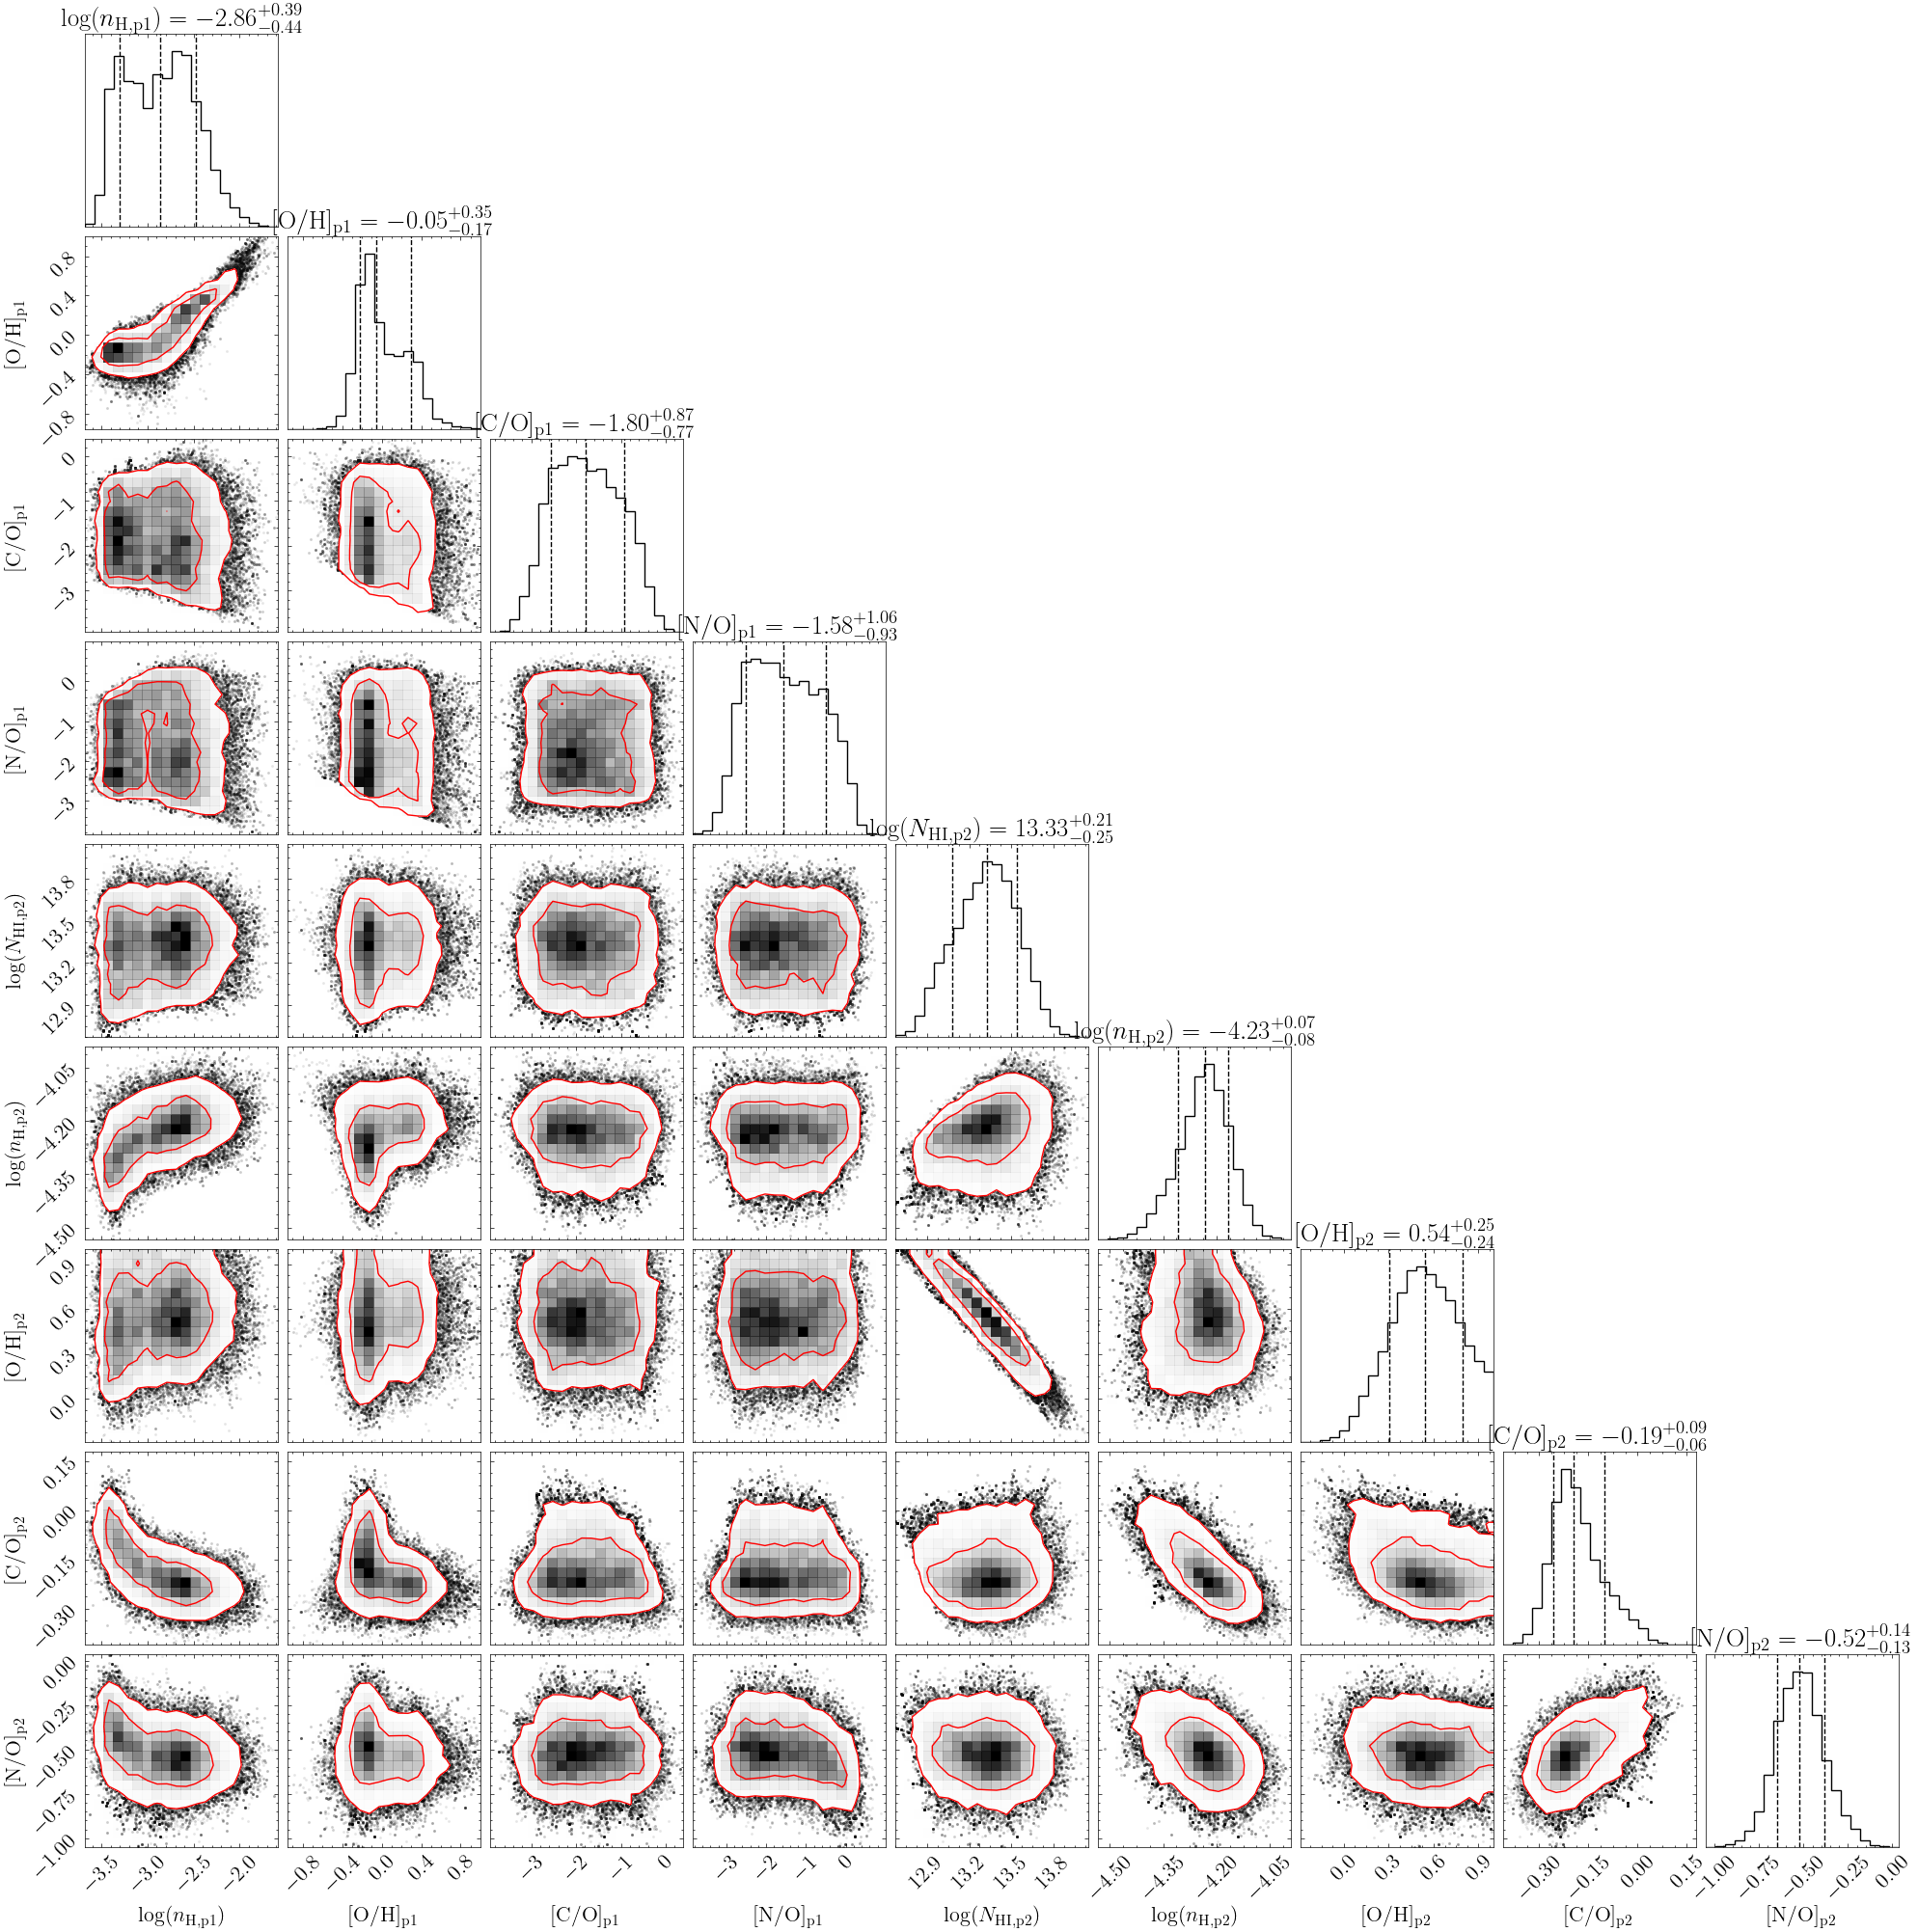

In [34]:
fig = corner.corner(
    flat_samples_two_phase, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H, p1})$', r'$[\mathrm{O/H}]_{\mathrm{p1}}$', r'$[\mathrm{C/O}]_{\mathrm{p1}}$', r'$[\mathrm{N/O}]_{\mathrm{p1}}$',
            r'$\log(N_\mathrm{HI, p2})$', r'$\log(n_\mathrm{H, p2})$', r'$[\mathrm{O/H}]_{\mathrm{p2}}$', r'$[\mathrm{C/O}]_{\mathrm{p2}}$', r'$[\mathrm{N/O}]_{\mathrm{p2}}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [35]:
np.median(flat_samples_two_phase['log_metals_p1'])

-0.05081177346590435

In [36]:
np.percentile(flat_samples_two_phase['C_O_p1'], 100*cdf_3sig), np.percentile(flat_samples_two_phase['N_O_p1'], 100*cdf_3sig)

(0.016531616047597, 0.4217152980340946)

In [37]:
np.percentile(flat_samples_two_phase['logN_HI_p2'], 100*(1-cdf_3sig)), np.percentile(flat_samples_two_phase['logN_HI_p2'], 100*cdf_3sig)

(12.73917076036802, 13.874550375206772)

In [38]:
np.percentile(flat_samples_two_phase['log_metals_p2'], 100*(1-cdf_3sig)), np.percentile(flat_samples_two_phase['log_metals_p2'], 100*cdf_3sig)

(-0.0998438861032619, 0.9973608451836452)

(array([  261.,  4596., 17074., 25833., 31940., 35635., 34658., 23994.,
         5829.,   180.]),
 array([-0.69615991, -0.25790174,  0.18035642,  0.61861459,  1.05687276,
         1.49513093,  1.9333891 ,  2.37164727,  2.80990544,  3.2481636 ,
         3.68642177]),
 <BarContainer object of 10 artists>)

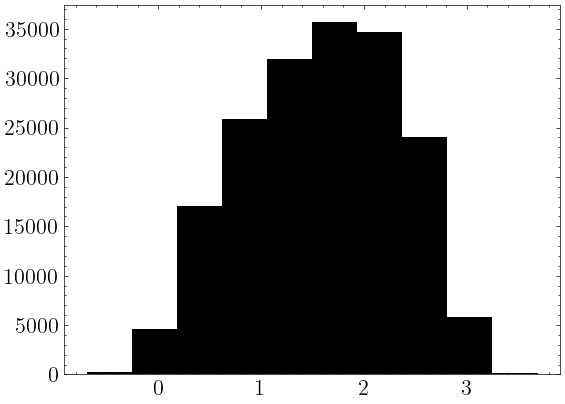

In [39]:
plt.hist(flat_samples_two_phase['C_O_p2']-flat_samples_two_phase['C_O_p1'])

In [40]:
np.percentile(flat_samples_two_phase['C_O_p2']-flat_samples_two_phase['C_O_p1'], 100*(1-cdf_3sig))

-0.2779455661764121

(array([   61.,  2538., 14641., 24012., 27370., 30871., 34631., 32975.,
        12196.,   705.]),
 array([-1.88411263, -1.36305076, -0.8419889 , -0.32092703,  0.20013484,
         0.7211967 ,  1.24225857,  1.76332044,  2.2843823 ,  2.80544417,
         3.32650604]),
 <BarContainer object of 10 artists>)

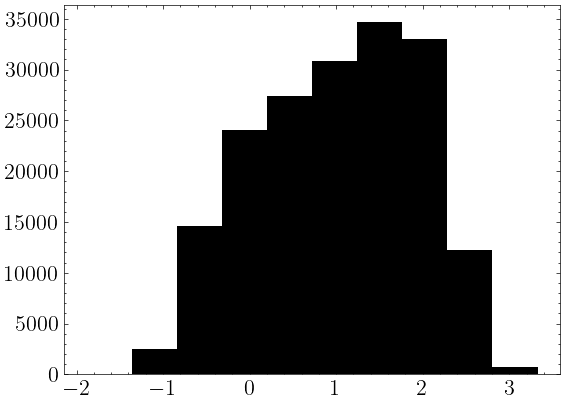

In [41]:
plt.hist(flat_samples_two_phase['N_O_p2']-flat_samples_two_phase['N_O_p1'])

In [42]:
np.percentile(flat_samples_two_phase['N_O_p2']-flat_samples_two_phase['N_O_p1'], 100*(1-cdf_3sig))

-1.2041504273527548

Now plot the best models

In [43]:
logN_dict = {#'HI':'14.09, -0.06, +0.06',
            'HeI':'<13.1',
            #'CII':'<13.4',
            'CIII':'12.9, -0.2, +0.1',
            'CIV':'13.65, -0.01, +0.01',
            #'NII':'<13.4',
            #'NIII':'<13.0',
            'NIV':'13.1, -0.1, +0.1',
            'OIII':'13.81, -0.09, +0.09',
            'OIV':'14.44, -0.04, +0.04',
            'OV':'14.4, -0.1, +0.2',
            'OVI':'14.64, -0.07, +0.09',
            'NeV':'14.17, -0.05, +0.05',
            'NeVI':'14.22, -0.05, +0.05',
            #'NeVIII':'<13.6'
            #'MgX':'<13.6',
            #'AlII':'<11.0',
            #'AlIII':'<11.4',
            #'SiII':'<14.0',
            'SiIII':'<12.0',
            'SiIV':'<12.0',
            'SIV':'<12.9',
            'SV':'<12.6',}
            #'SVI':'<13.2',}
            #'FeII':'<11.8',}

In [44]:
b_dict = {'HI':'24, -2, +3',
          'CIII':'11.1, -0.2, +0.2',
          'CIV':'11.1, -0.2, +0.2',
          'NIV':'12, -4, +6',
          'OIII':'11.9, -0.9, +0.9',
          'OIV':'11.9, -0.9, +0.9',
          'OV':'17, -1, +1',
          'OVI':'17, -1, +1',
          'NeV':'21, -3, +4',
          'NeVI':'21, -3, +4'}

In [45]:
z_sys = 1.27767328

In [46]:
import matplotlib.lines as mlines

In [47]:
logN_species_p1_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples_two_phase['log_hdens_p1'], flat_samples_two_phase['log_metals_p1'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p1'], 'N':flat_samples_two_phase['N_O_p1']})

logN_species_p2_grid = predict_col_dens(logN_dict, flat_samples_two_phase['logN_HI_p2'], flat_samples_two_phase['log_hdens_p2'], flat_samples_two_phase['log_metals_p2'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p2'], 'N':flat_samples_two_phase['N_O_p2']})

logN_species_grid = np.log10(10**logN_species_p1_grid + 10**logN_species_p2_grid)

# Medians and errorbars for plotting
logN_species_p1_med = np.median(logN_species_p1_grid, axis=1)
logN_species_p1_lo = np.percentile(logN_species_p1_grid, 100*(1-cdf_1sig), axis=1)
logN_species_p1_hi = np.percentile(logN_species_p1_grid, 100*cdf_1sig, axis=1)

logN_species_p2_med = np.median(logN_species_p2_grid, axis=1)
logN_species_p2_lo = np.percentile(logN_species_p2_grid, 100*(1-cdf_1sig), axis=1)
logN_species_p2_hi = np.percentile(logN_species_p2_grid, 100*cdf_1sig, axis=1)

logN_species_med = np.median(logN_species_grid, axis=1)
logN_species_lo = np.percentile(logN_species_grid, 100*(1-cdf_1sig), axis=1)
logN_species_hi = np.percentile(logN_species_grid, 100*cdf_1sig, axis=1)

In [51]:
ll = 0

for i in range(len(logN_species_med)):
    k = list(logN_dict.keys())[i]
    logN_str = logN_dict[k]
    ybar = logN_species_med[i]
    ll += compute_ll(logN_str, ybar)

In [52]:
ll

-3983.5233423347545

In [59]:
ll = 0

for i in range(len(logN_species_med)):
    k = list(logN_dict.keys())[i]
    logN_str = logN_dict[k]
    ybar = logN_species_med[i]
    if k in ['OIII','SiIII','SiIV']:
        ybar += .1
    ll += compute_ll(logN_str, ybar)

In [60]:
ll

-3987.7223818636185

In [61]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_med, logN_species_lo, logN_species_hi)

In [62]:
logN_res_up = {k:'<1.2' for k in list(logN_res_dict.keys())}

logN_res_up['SIV'] = '<0.5'

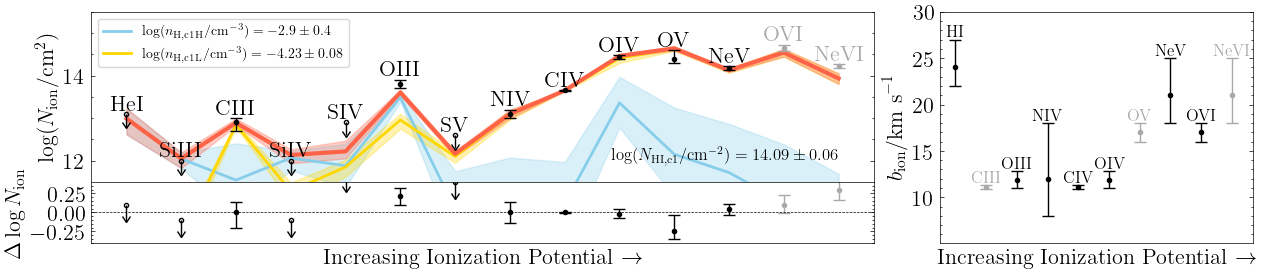

In [63]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

axd['upper left'].fill_between(np.arange(len(logN_dict)), logN_species_p1_lo, logN_species_p1_hi,
                color='skyblue', alpha=.3)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p1_med, color='skyblue', lw=2, alpha=1)

axd['upper left'].fill_between(np.arange(len(logN_dict)), logN_species_p2_lo, logN_species_p2_hi,
                color='gold', alpha=.3)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p2_med, color='gold', lw=2, alpha=1)

axd['upper left'].fill_between(np.arange(len(logN_dict)), logN_species_lo, logN_species_hi,
                color='tomato', alpha=.3)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_med, color='tomato', lw=3, alpha=1)

    
plot_column_densities_obs(logN_dict, fig, axd['upper left'],
                          gray_out = ['OVI', 'NeVI'])

axd['upper left'].set_ylim(11.5,15.5)

#axd['upper left'].text(len(logN_dict)-1, 15.7, r'PIE',fontsize=14, horizontalalignment='right')

axd['upper left'].text(len(logN_dict)-1, 12.0, r'$\log(N_\mathrm{HI, c1}/\mathrm{cm}^{-2}) = 14.09 \pm 0.06$', fontsize=12,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='skyblue', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c1H}/\mathrm{cm}^{-3}) = -2.9 \pm 0.4$'))

handles.append(mlines.Line2D([], [], lw=2,
                             color='gold', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c1L}/\mathrm{cm}^{-3}) = -4.23 \pm 0.08$'))
    
axd['upper left'].legend(handles=handles, loc='upper left', fontsize=10)

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'],
                         gray_out = ['OVI', 'NeVI'], label_ions=False, dy=.15)
plot_column_densities_obs(logN_res_up, fig, axd['lower left'],
                         gray_out = ['OVI', 'NeVI'], label_ions=False, dy=.15)


axd['lower left'].set_ylim(-0.4,0.4)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'], fs=12, gray_out=['CIII','OV','NeVI'])
axd['right'].set_xlim(-0.5, len(b_dict)-1+.7)
axd['right'].set_ylim(5.1,30)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)
plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)

Get cloud sizes

In [46]:
l_p1 = get_cloud_size(logN_HI_test, flat_samples_two_phase['log_hdens_p1'], species_logN_interp, flat_samples_two_phase['log_metals_p1'])
l_p2 = get_cloud_size(flat_samples_two_phase['logN_HI_p2'], flat_samples_two_phase['log_hdens_p2'], species_logN_interp, flat_samples_two_phase['log_metals_p2'])

Text(0, 0.5, 'Counts')

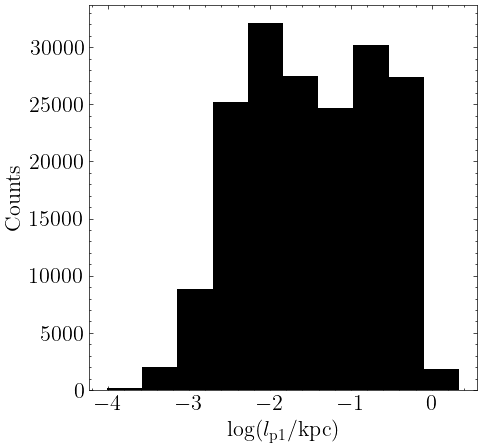

In [47]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l_p1), bins=10)

ax.set_xlabel(r'$\log(l_{\mathrm{p1}}/\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [48]:
get_quantiles(np.log10(l_p1))

-1.49 -0.9 0.97


In [49]:
np.percentile(np.log10(l_p1), 100*cdf_3sig)

0.08402773478892621

Text(0, 0.5, 'Counts')

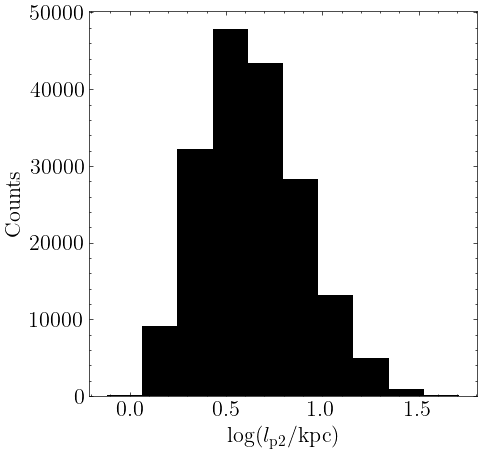

In [50]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l_p2), bins=10)

ax.set_xlabel(r'$\log(l_{\mathrm{p2}}/\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [51]:
get_quantiles(np.log10(l_p2))

0.62 -0.24 0.29


In [52]:
np.percentile(np.log10(l_p2), 100*(1-cdf_3sig)), np.percentile(np.log10(l_p2), 100*cdf_3sig)

(0.07445164993319753, 1.4819614404476833)

In [53]:
np.log10(0.03*(10**-4.22/10**-3)**-1), np.log10(40*(10**-4.22/10**-3)**-0.5)

(-0.30287874528033776, 2.2120599913279624)

# c2

## Column density ratios

Enter measurements for species

In [83]:
logN_dict = {'HI':'13.99, -0.07, +0.07',
            'HeI':'<13.1',
            'CII':'<13.4',
            'CIII':'12.9, -0.2, +0.1',
            'CIV':'13.43, -0.01, +0.01',
            'NII':'<13.4',
            'NIII':'<13.0',
            'NIV':'<13.0',
            'OIII':'<13.7',
            'OIV':'14.13, -0.04, +0.04',
            'OV':'14.3, -0.2, +0.4',
            'OVI':'14.1, -0.1, +0.1',
            'NeV':'13.79, -0.08, +0.08',
            'NeVI':'13.97, -0.07, +0.07',
            'NeVIII':'<14.0',
            'MgX':'<13.6',
            'AlII':'<11.0',
            'AlIII':'<11.4',
            'SiII':'<14.0',
            'SiIII':'<12.2',
            'SiIV':'<12.0',
            'SIV':'<12.9',
            'SV':'<12.9',
            'SVI':'<13.5',
            'FeII':'<11.8',}

Get column density ratios

In [84]:
gen_logN_ratio_str(logN_dict['CIV'], logN_dict['CIII'])

'0.53, -0.20, 0.10'

In [85]:
logN_ratio_dict = {'OV/OIV': '0.52, -0.30, 0.50',
                   'OVI/OIV': '-0.08, -0.11, 0.11',
                   'CIV/CIII': '0.51, -0.20, 0.10'}

Generate predicted column density ratios

(-5.0, 2.0)

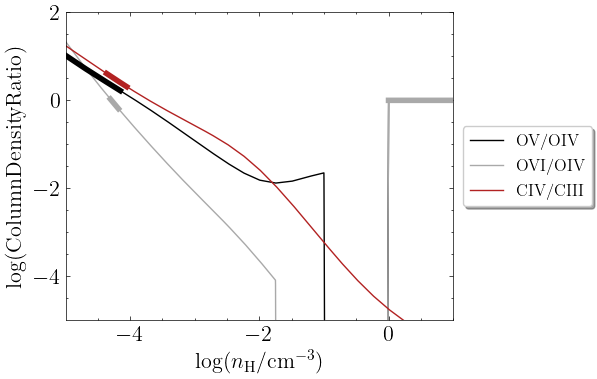

In [86]:
fig, ax = plt.subplots(1, figsize=(5,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict)

ax.set_xlim(-5,1)
ax.set_ylim(-5, 2)

## Single phase solution

In [87]:
def lambda_log_prior(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O, N_O = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O, 'N':N_O}])
    
    return log_prior(params_full)

In [88]:
def lambda_log_likelihood(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O, N_O = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O, 'N':N_O}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood(params_full, logN_dict, species_logN_interp)    

In [89]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood(params, logN_dict, species_logN_interp)

In [102]:
logN_dict = {#'HI':'13.99, -0.07, +0.07',
            #'HeI':'<13.1',
            #'CII':'<13.4',
            'CIII':'12.9, -0.2, +0.1',
            'CIV':'13.43, -0.01, +0.01',
            'NII':'<13.4',
            'NIII':'<13.0',
            'NIV':'<13.0',
            'OIII':'<13.7',
            'OIV':'14.13, -0.04, +0.04',
            'OV':'14.3, -0.2, +0.4',
            'OVI':'14.1, -0.1, +0.1',
            #'NeV':'13.79, -0.08, +0.08',
            #'NeVI':'13.97, -0.07, +0.07',
            #'NeVIII':'<14.0',
            #'MgX':'<13.6',
            #'AlII':'<11.0',
            #'AlIII':'<11.4',
            'SiII':'<14.0',
            'SiIII':'<12.2',
            'SiIV':'<12.0',
            'SIV':'<12.9',
            'SV':'<12.9',
            'SVI':'<13.5',}
            #'FeII':'<11.8',}

In [103]:
logN_HI_test = 13.99
log_hdens_test = -4.1
log_metals_test = -0.4
C_O_test = -0.15
N_O_test = -1.0

In [104]:
logN_species_test = np.array(predict_col_dens(logN_dict, logN_HI_test, log_hdens_test, log_metals_test, species_logN_interp, {'C':C_O_test, 'N':N_O_test}))

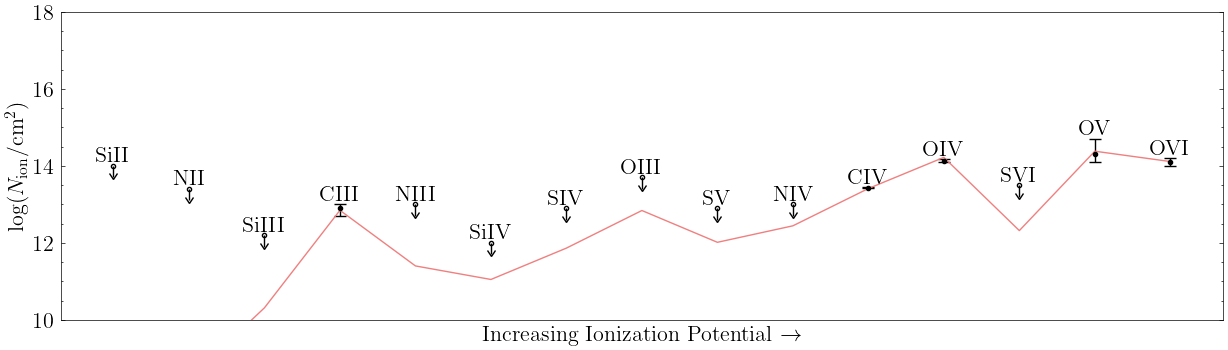

In [105]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [106]:
pos = np.array([log_hdens_test, log_metals_test, C_O_test, N_O_test]) + 1e-7 * np.random.randn(200, 4)
nwalkers, ndim = pos.shape

In [107]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [108]:
sampler.run_mcmc(pos, 500, progress=True);

100%|█████████████████████████████████████████| 500/500 [02:53<00:00,  2.88it/s]


In [110]:
flat_samples = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
                                columns=['log_hdens', 'log_metals', 'C_O', 'N_O'])
flat_samples.to_csv(savedir+'one_phase_c2.csv', index=False)

#flat_samples = pd.read_csv(savedir+'one_phase_c2.csv')

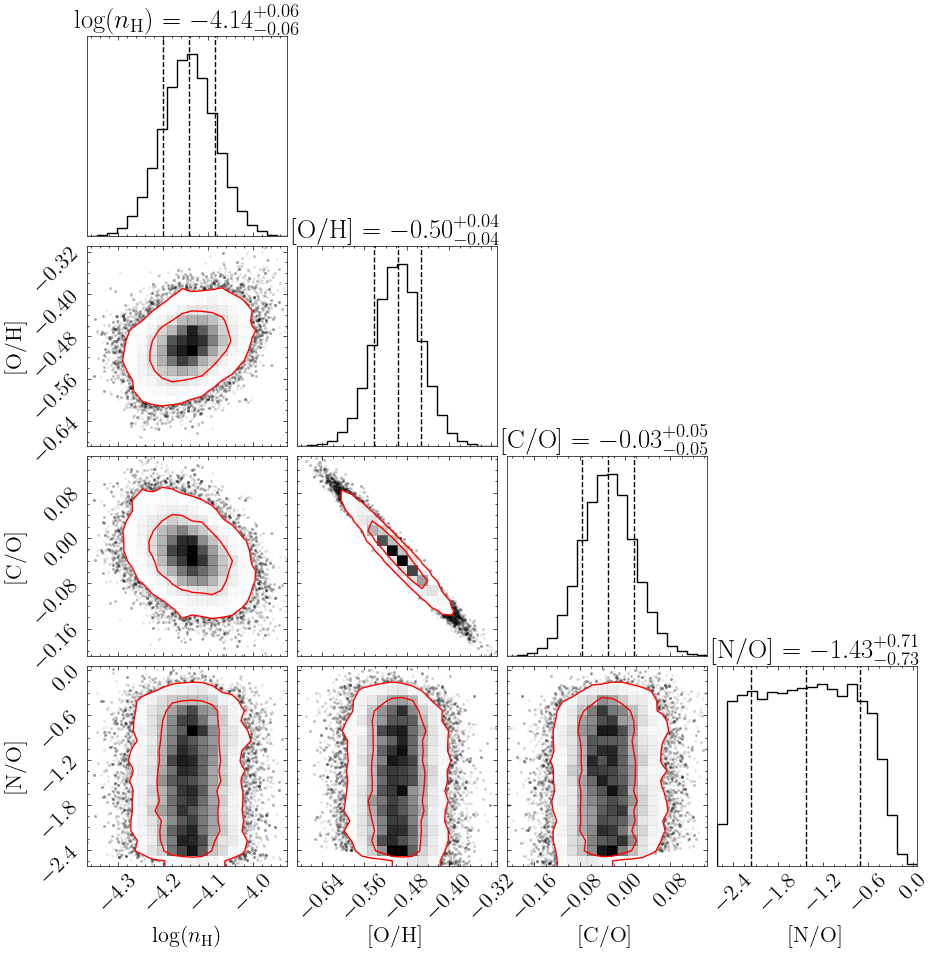

In [111]:
fig = corner.corner(
    flat_samples, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$', r'$[\mathrm{O/H}]$', r'$[\mathrm{C/O}]$', r'$[\mathrm{N/O}]$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [112]:
np.percentile(flat_samples['N_O'], 100*cdf_3sig)

-0.11176855973276645

Now plot the best models

In [113]:
logN_dict = {#'HI':'13.99, -0.07, +0.07',
            #'HeI':'<13.1',
            #'CII':'<13.4',
            'CIII':'12.9, -0.2, +0.1',
            'CIV':'13.43, -0.01, +0.01',
            #'NII':'<13.4',
            #'NIII':'<13.0',
            'NIV':'<13.0',
            'OIII':'<13.7',
            'OIV':'14.13, -0.04, +0.04',
            'OV':'14.3, -0.2, +0.4',
            'OVI':'14.1, -0.1, +0.1',
            'NeV':'13.79, -0.08, +0.08',
            'NeVI':'13.97, -0.07, +0.07',
            'NeVIII':'<14.0',
            #'MgX':'<13.6',
            #'AlII':'<11.0',
            #'AlIII':'<11.4',
            #'SiII':'<14.0',
            #'SiIII':'<12.2',
            #'SiIV':'<12.0',
            'SIV':'<12.9',
            'SV':'<12.9',
            'SVI':'<13.5',}
            #'FeII':'<11.8',}

In [114]:
b_dict = {'HI':'38, -9, +10',
          'CIII': '9.2, -0.3, +0.3',
          'CIV': '9.2, -0.3, +0.3',
          'OIV': '13, -2, +2',
          'OV': '13, -2, +2',
          'OVI': '13, -2, +2',
          'NeV': '13, -2, +2',
          'NeVI': '13, -2, +2'}

In [115]:
z_sys = 1.27767214

In [116]:
import matplotlib.lines as mlines

In [117]:
logN_species_best = predict_col_dens(logN_dict, logN_HI_test, np.median(flat_samples['log_hdens']), 
                                        np.median(flat_samples['log_metals']), 
                                        species_logN_interp, {'C':np.median(flat_samples['C_O']), 
                                                              'N':np.median(flat_samples['N_O'])})

In [118]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_best)

In [119]:
logN_res_up = {k:'<1.2' for k in list(logN_res_dict.keys())}

#logN_res_up['SiIV'] = '<0.27'
logN_res_up['OIII'] = '<0.53'
logN_res_up['SIV'] = '<0.53'
logN_res_up['SV'] = '<0.53'
logN_res_up['NIV'] = '<0.53'
logN_res_up['SVI'] = '<0.53'
#logN_res_up['NeVI'] = '<0.27'
logN_res_up['NeVIII'] = '<0.53'

In [120]:
# Model curves for each step
logN_species_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples['log_hdens'], flat_samples['log_metals'], 
                                                 species_logN_interp, {'C':flat_samples['C_O'], 'N':flat_samples['N_O']})

In [121]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_lo = np.percentile(flat_samples['log_hdens'], 100*(1-cdf_1sig))
log_hdens_hi = np.percentile(flat_samples['log_hdens'], 100*cdf_1sig)

log_metals_lo = np.percentile(flat_samples['log_metals'], 100*(1-cdf_1sig))
log_metals_hi = np.percentile(flat_samples['log_metals'], 100*cdf_1sig)

C_O_lo = np.percentile(flat_samples['C_O'], 100*(1-cdf_1sig))
C_O_hi = np.percentile(flat_samples['C_O'], 100*cdf_1sig)

N_O_lo = np.percentile(flat_samples['N_O'], 100*(1-cdf_1sig))
N_O_hi = np.percentile(flat_samples['N_O'], 100*cdf_1sig)

for i in range(len(flat_samples)):
    log_hdens = flat_samples['log_hdens'][i]
    log_metals = flat_samples['log_metals'][i]
    C_O = flat_samples['C_O'][i]
    N_O = flat_samples['N_O'][i]
    
    if log_hdens_lo<log_hdens<log_hdens_hi and log_metals_lo<log_metals<log_metals_hi and C_O_lo<C_O<C_O_hi and N_O_lo<N_O<N_O_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

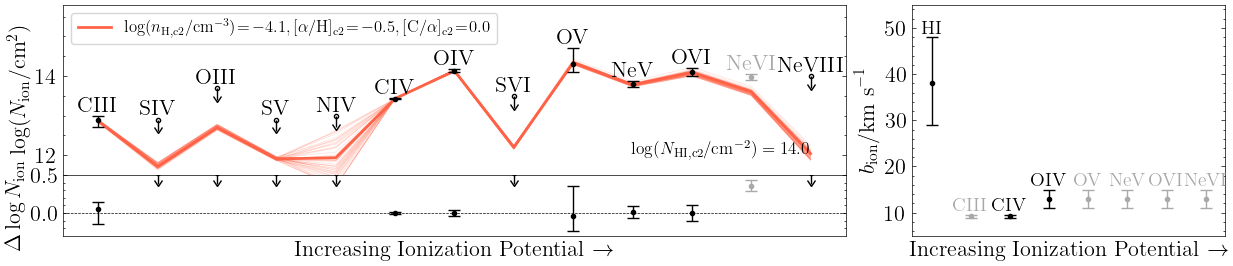

In [123]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

for idx in plot_idx:
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)

    
plot_column_densities_obs(logN_dict, fig, axd['upper left'], gray_out=['NeVI'])

axd['upper left'].set_ylim(11.5,15.8)

axd['upper left'].text(len(logN_dict)-1, 12., r'$\log(N_\mathrm{HI, c2}/\mathrm{cm}^{-2}) = 14.0$', fontsize=12.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c2}/\mathrm{cm}^{-3}) \!=\! -4.1, \mathrm{[\alpha/H]_{c2}} \!=\! -0.5, \mathrm{[C/\alpha]_{c2}}\!=\!0.0$'))

axd['upper left'].legend(handles=handles, loc='upper left', fontsize=12)

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'],
                          gray_out = ['NeVI'], label_ions=False, dy=.1)
plot_column_densities_obs(logN_res_up, fig, axd['lower left'],
                          gray_out = ['NeVI'], label_ions=False, dy=.1)

axd['lower left'].set_ylim(-0.3,0.5)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'], fs=14, gray_out=['CIII','OV','NeV','OVI','NeVI'])
axd['right'].set_xlim(-0.5, len(b_dict)-1+0.5)
axd['right'].set_ylim(5,55)

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_cloudy_c2_op.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

Get cloud sizes

In [124]:
l = get_cloud_size(logN_HI_test, flat_samples['log_hdens'], species_logN_interp, flat_samples['log_metals'])

Text(0, 0.5, 'Counts')

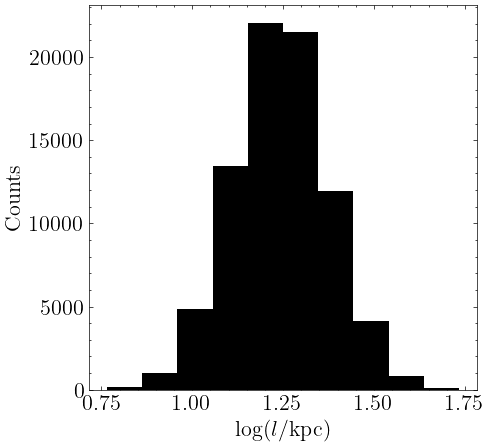

In [125]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l), bins=10)

ax.set_xlabel(r'$\log(l/\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [126]:
get_quantiles(np.log10(l))

1.24 -0.13 0.13


In [127]:
get_cloud_size(14, -4, species_logN_interp, -0.5)

8.801601994199967

## Two-phase solution

In [88]:
def lambda_log_prior_two_phase(params, species_logN_interp):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O_p1, N_O_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, N_O_p2 = params
    
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C': C_O_p1, 'N': N_O_p1},
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {'C': C_O_p2, 'N': N_O_p2}])
    
    x = log_prior_two_phase(params_full, species_logN_interp)

    if np.isfinite(x):
        l = get_cloud_size(logN_HI_test, log_hdens_p1, species_logN_interp, log_metals_p1)
        if np.log10(l) > np.log10(0.03*(10**log_hdens_p2/1e-3)**-1):
            return x
        else:
            return -np.inf
    else:
        return -np.inf

In [89]:
def lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O_p1, N_O_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, N_O_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C': C_O_p1, 'N': N_O_p1},
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {'C': C_O_p2, 'N': N_O_p2}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood_two_phase(params_full, logN_dict, species_logN_interp)    

In [90]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_two_phase(params, species_logN_interp)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp)

Fit things

In [91]:
logN_dict = {'HI':'13.99, -0.07, +0.07',
        'HeI':'<13.1',
        'CII':'<13.4',
        'CIII':'<12.7',
        'CIV':'13.41, -0.01, +0.01',
        'NII':'<13.4',
        'NIII':'<13.0',
        'NIV':'<12.7',
        'OIII':'<13.4',
        'OIV':'14.21, -0.05, +0.05',
        'OV':'14.3, -0.1, +0.2',
        'OVI':'14.04, -0.08, +0.08',
        'NeV':'13.7, -0.1, +0.1',
        'NeVI':'<13.94',
        #'NeVIII':'<13.6',
        #'MgX':'<13.6',
        #'AlII':'<11.0',
        #'AlIII':'<11.4',
        'SiII':'<14.0',
        'SiIII':'<12.0',
        'SiIV':'<12.0',
        'SIV':'<12.9',
        'SV':'<12.6',
        'SVI':'<13.2',}
        #'FeII':'<11.8'}

In [92]:
logN_HI_test = 13.99
log_hdens_test_p1 = -3.4
log_metals_test_p1 = -1.0
C_O_test_p1 = -1.0
N_O_test_p1 = -1.0

logN_HI_test_p2 = 13.2
log_hdens_test_p2 = -4.1
log_metals_test_p2 = 0.4
C_O_test_p2 = -0.2
N_O_test_p2 = -2.0

In [93]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, 
                                                 logN_HI_test, 
                                                 log_hdens_test_p1, 
                                                 log_metals_test_p1, 
                                                 species_logN_interp,
                                                 {'C': C_O_test_p1, 'N': N_O_test_p1}))

logN_species_test_p2 = np.array(predict_col_dens(logN_dict, 
                                                 logN_HI_test_p2, 
                                                 log_hdens_test_p2, 
                                                 log_metals_test_p2, 
                                                 species_logN_interp,
                                                 {'C': C_O_test_p2, 'N': N_O_test_p2}))

logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

In [94]:
get_cloud_size(logN_HI_test, log_hdens_test_p1, species_logN_interp, log_metals_test_p1)

0.5565253548920516

In [95]:
get_cloud_size(logN_HI_test_p2, log_hdens_test_p2, species_logN_interp, log_metals_test_p2)

1.6343925937040622

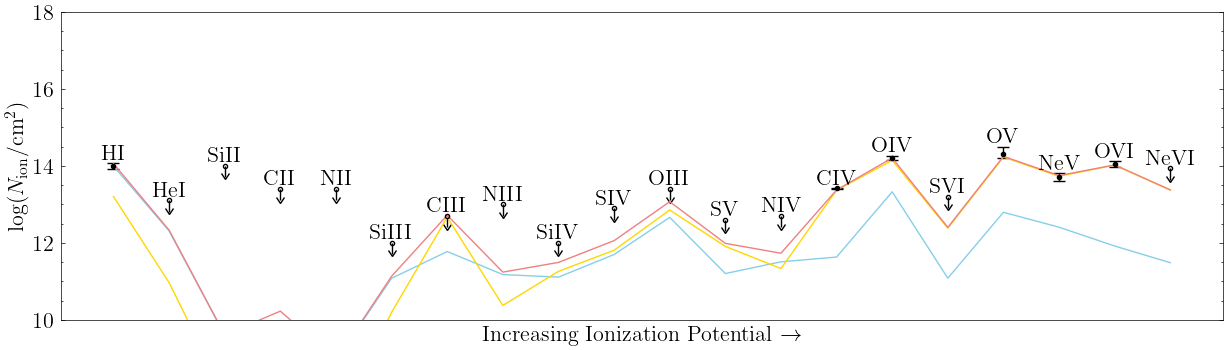

In [96]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='skyblue')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [97]:
pos = np.array([log_hdens_test_p1, log_metals_test_p1, C_O_test_p1, N_O_test_p1,
                logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, C_O_test_p2, N_O_test_p2]) + 1e-4 * np.random.randn(200, 9)
nwalkers, ndim = pos.shape

In [98]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [99]:
#sampler.run_mcmc(pos, 1000, progress=True);

In [100]:
#flat_samples_two_phase = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens_p1', 'log_metals_p1', 'C_O_p1', 'N_O_p1', 
#                                         'logN_HI_p2', 'log_hdens_p2', 'log_metals_p2', 'C_O_p2', 'N_O_p2'])
#flat_samples_two_phase.to_csv(savedir+'two_phase_c2.csv', index=False)

flat_samples_two_phase = pd.read_csv(savedir+'two_phase_c2.csv')

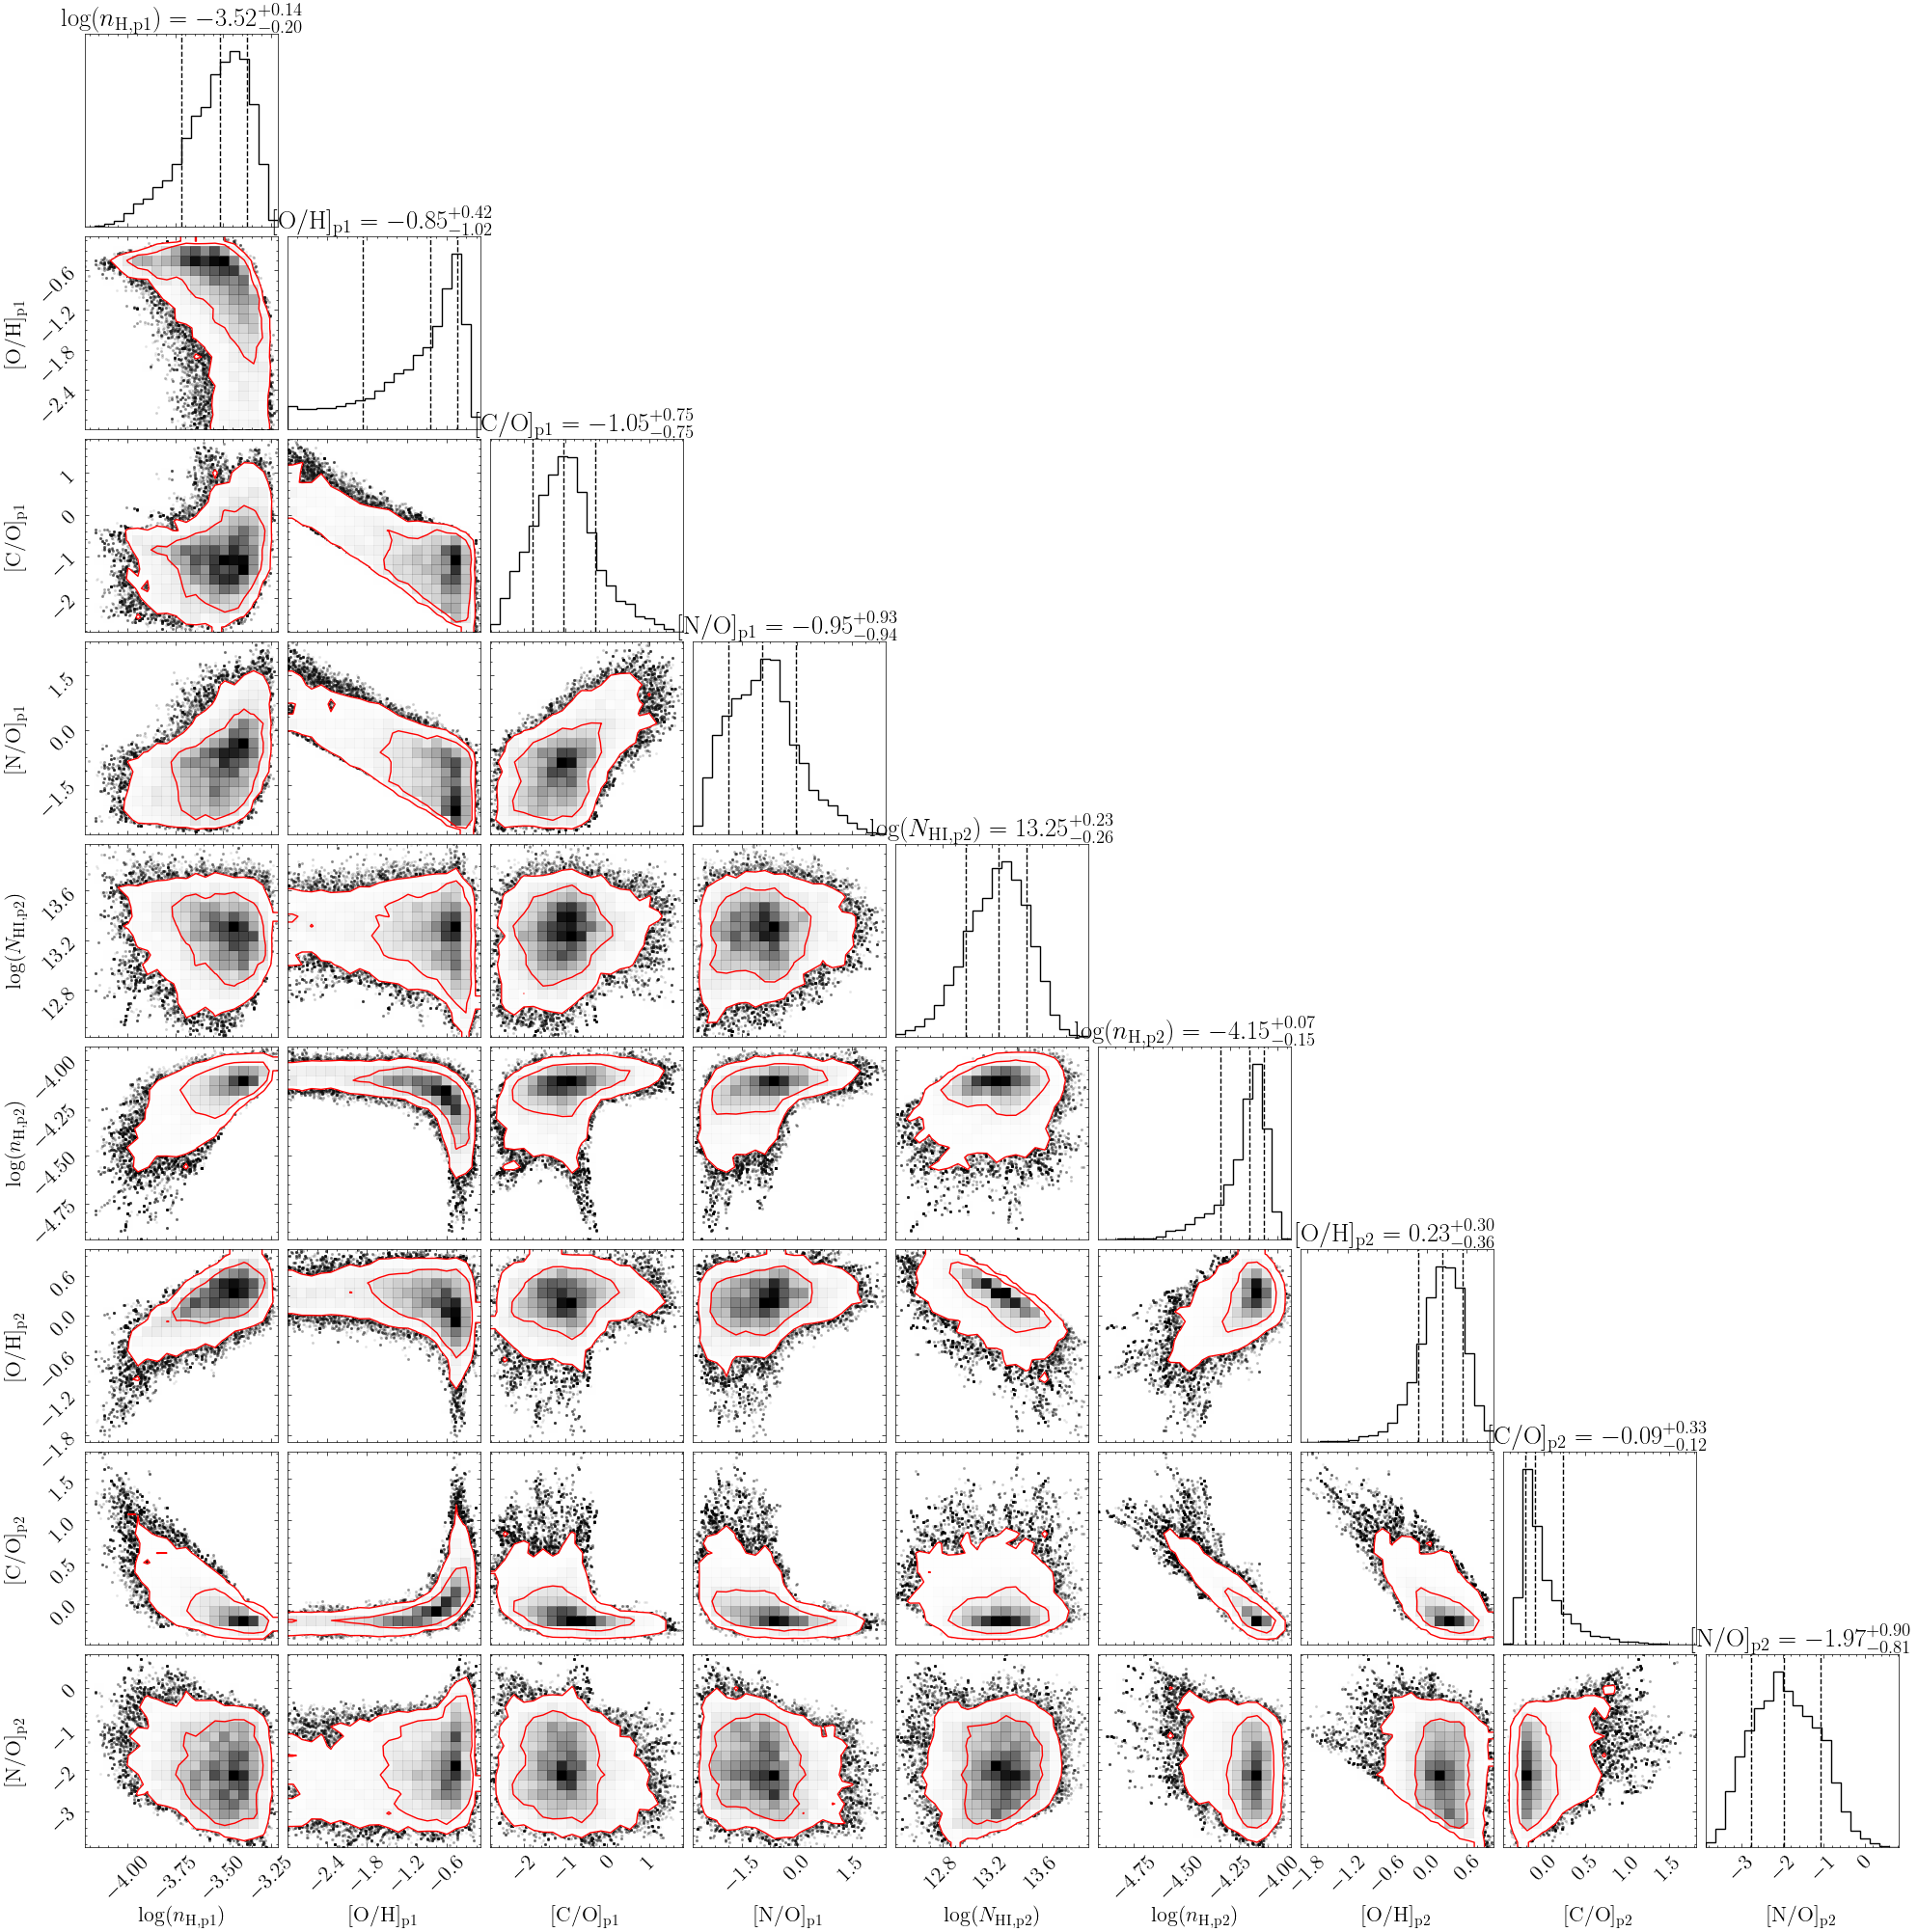

In [101]:
fig = corner.corner(
    flat_samples_two_phase, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H, p1})$', r'$[\mathrm{O/H}]_{\mathrm{p1}}$', r'$[\mathrm{C/O}]_{\mathrm{p1}}$', r'$[\mathrm{N/O}]_{\mathrm{p1}}$',
            r'$\log(N_\mathrm{HI, p2})$', r'$\log(n_\mathrm{H, p2})$', r'$[\mathrm{O/H}]_{\mathrm{p2}}$', r'$[\mathrm{C/O}]_{\mathrm{p2}}$', r'$[\mathrm{N/O}]_{\mathrm{p2}}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [102]:
np.percentile(flat_samples_two_phase['log_metals_p1'], 100*cdf_3sig)

-0.1609277268729262

In [103]:
np.percentile(flat_samples_two_phase['C_O_p1'], 100*cdf_3sig), np.percentile(flat_samples_two_phase['N_O_p1'], 100*cdf_3sig)

(1.4868519678626433, 1.980671800648744)

In [104]:
np.percentile(flat_samples_two_phase['logN_HI_p2'], 100*(1-cdf_3sig)), np.percentile(flat_samples_two_phase['logN_HI_p2'], 100*cdf_3sig)

(12.476561269354423, 13.838880255009162)

In [105]:
np.median(flat_samples_two_phase['log_hdens_p2'])

-4.14571193811893

In [106]:
np.median(flat_samples_two_phase['log_hdens_p2'])-np.percentile(flat_samples_two_phase['log_hdens_p2'],100*(1-cdf_1sig))

0.15109499642265511

In [107]:
np.percentile(flat_samples_two_phase['log_metals_p2'], 100*(1-cdf_3sig)), np.percentile(flat_samples_two_phase['log_metals_p2'], 100*cdf_3sig)

(-1.4844230371957372, 0.9457780120474978)

In [108]:
np.percentile(flat_samples_two_phase['N_O_p2'], 100*cdf_3sig)

0.3535373018303849

(array([  709.,  4071.,  9459., 19841., 35586., 48610., 36461., 17329.,
         6525.,  1409.]),
 array([-2.11116368, -1.52482156, -0.93847944, -0.35213732,  0.2342048 ,
         0.82054692,  1.40688904,  1.99323116,  2.57957329,  3.16591541,
         3.75225753]),
 <BarContainer object of 10 artists>)

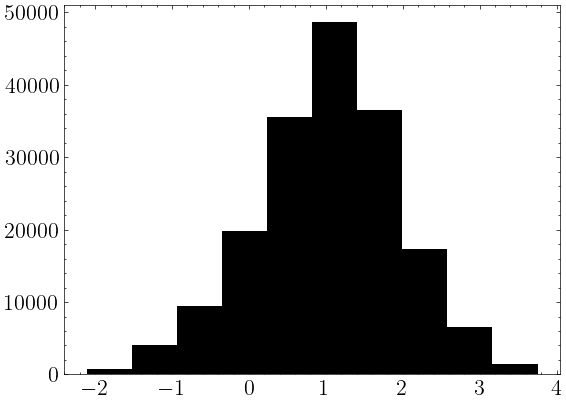

In [109]:
plt.hist(flat_samples_two_phase['C_O_p2']-flat_samples_two_phase['C_O_p1'])

In [110]:
np.percentile(flat_samples_two_phase['C_O_p2']-flat_samples_two_phase['C_O_p1'], 100*(1-cdf_3sig))

-1.7043137340641215

Now plot the best models

In [111]:
logN_dict = {#'HI':'13.99, -0.07, +0.07',
        'HeI':'<13.1',
        #'CII':'<13.4',
        'CIII':'<12.7',
        'CIV':'13.41, -0.01, +0.01',
        #'NII':'<13.4',
        #'NIII':'<13.0',
        'NIV':'<12.7',
        'OIII':'<13.4',
        'OIV':'14.21, -0.05, +0.05',
        'OV':'14.3, -0.1, +0.2',
        'OVI':'14.04, -0.08, +0.08',
        'NeV':'13.7, -0.1, +0.1',
        'NeVI':'13.94, -0.08, +0.08',
        #'NeVIII':'<13.6',
        #'MgX':'<13.6',
        #'AlII':'<11.0',
        #'AlIII':'<11.4',
        #'SiII':'<14.0',
        'SiIII':'<12.0',
        'SiIV':'<12.0',
        'SIV':'<12.9',
        'SV':'<12.6',
        'SVI':'<13.2',}
        #'FeII':'<11.8'}

In [112]:
b_dict = {'HI':'26, -4, +5',
          'CIV':'16, -3, +3',
          'OIV':'21, -2, +2',
          'OV':'21, -2, +2',
          'OVI':'21, -2, +2'}

In [113]:
z_sys = 1.27767328

In [114]:
import matplotlib.lines as mlines

In [115]:
logN_species_p1_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples_two_phase['log_hdens_p1'], flat_samples_two_phase['log_metals_p1'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p1'], 'N':flat_samples_two_phase['N_O_p1']})

logN_species_p2_grid = predict_col_dens(logN_dict, flat_samples_two_phase['logN_HI_p2'], flat_samples_two_phase['log_hdens_p2'], flat_samples_two_phase['log_metals_p2'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p2'], 'N':flat_samples_two_phase['N_O_p2']})

logN_species_grid = np.log10(10**logN_species_p1_grid + 10**logN_species_p2_grid)

# Medians and errorbars for plotting
logN_species_p1_med = np.median(logN_species_p1_grid, axis=1)
logN_species_p1_lo = np.percentile(logN_species_p1_grid, 100*(1-cdf_1sig), axis=1)
logN_species_p1_hi = np.percentile(logN_species_p1_grid, 100*cdf_1sig, axis=1)

logN_species_p2_med = np.median(logN_species_p2_grid, axis=1)
logN_species_p2_lo = np.percentile(logN_species_p2_grid, 100*(1-cdf_1sig), axis=1)
logN_species_p2_hi = np.percentile(logN_species_p2_grid, 100*cdf_1sig, axis=1)

logN_species_med = np.median(logN_species_grid, axis=1)
logN_species_lo = np.percentile(logN_species_grid, 100*(1-cdf_1sig), axis=1)
logN_species_hi = np.percentile(logN_species_grid, 100*cdf_1sig, axis=1)

In [116]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_med, logN_species_lo, logN_species_hi)

In [117]:
logN_res_up = {k:'<1.2' for k in list(logN_res_dict.keys())}

logN_res_up['HeI'] = '<0.35'
logN_res_up['SiIII'] = '<0.35'
logN_res_up['SiIV'] = '<0.35'
logN_res_up['SIV'] = '<0.35'
logN_res_up['SV'] = '<0.35'
logN_res_up['NIV'] = '<0.35'
logN_res_up['SVI'] = '<0.35'
logN_res_up['NeVI'] = '<0.35'

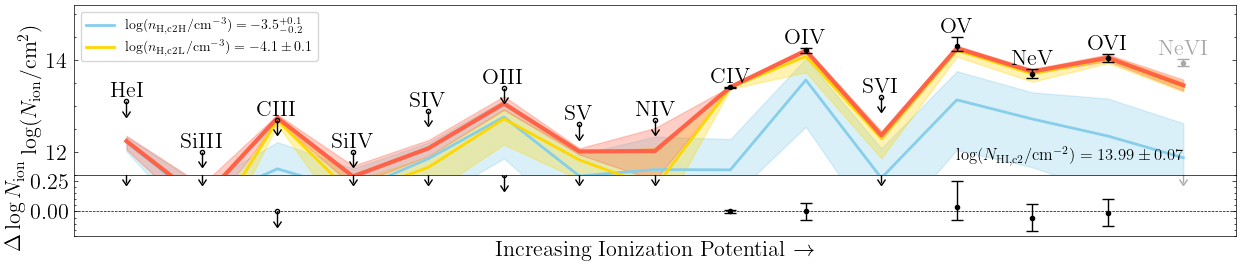

In [118]:
fig, axes = plt.subplots(2, 1, figsize=(15,3.), gridspec_kw={'height_ratios': [2.8, 1]})

axes[0].fill_between(np.arange(len(logN_dict)), logN_species_p1_lo, logN_species_p1_hi,
                color='skyblue', alpha=.3)
axes[0].plot(np.arange(len(logN_dict)), logN_species_p1_med, color='skyblue', lw=2, alpha=1)

axes[0].fill_between(np.arange(len(logN_dict)), logN_species_p2_lo, logN_species_p2_hi,
                color='gold', alpha=.3)
axes[0].plot(np.arange(len(logN_dict)), logN_species_p2_med, color='gold', lw=2, alpha=1)

axes[0].fill_between(np.arange(len(logN_dict)), logN_species_lo, logN_species_hi,
                color='tomato', alpha=.3)
axes[0].plot(np.arange(len(logN_dict)), logN_species_med, color='tomato', lw=3, alpha=1)

    
plot_column_densities_obs(logN_dict, fig, axes[0], gray_out = ['NeVI'])

axes[0].set_ylim(11.5,15.2)

axes[0].text(len(logN_dict)-1, 11.8, r'$\log(N_\mathrm{HI, c2}/\mathrm{cm}^{-2}) = 13.99 \pm 0.07$', fontsize=12,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='skyblue', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c2H}/\mathrm{cm}^{-3}) = -3.5_{-0.2}^{+0.1}$'))

handles.append(mlines.Line2D([], [], lw=2,
                             color='gold', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c2L}/\mathrm{cm}^{-3}) = -4.1 \pm 0.1$'))
    
axes[0].legend(handles=handles, loc='upper left', fontsize=10)

plot_column_densities_obs(logN_res_dict, fig, axes[1], gray_out = ['NeVI'], label_ions=False, dy=.08)
plot_column_densities_obs(logN_res_up, fig, axes[1], gray_out = ['NeVI'], label_ions=False, dy=.08)

axes[1].set_ylim(-0.2,0.3)
axes[1].axhline(0, linestyle='--', lw=.5)
axes[1].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plt.subplots_adjust(wspace=0.12, hspace=0) 

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_cloudy_c2_tp.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

Get cloud sizes

In [263]:
l_p1 = get_cloud_size(logN_HI_test, flat_samples_two_phase['log_hdens_p1'], species_logN_interp, flat_samples_two_phase['log_metals_p1'])
l_p2 = get_cloud_size(flat_samples_two_phase['logN_HI_p2'], flat_samples_two_phase['log_hdens_p2'], species_logN_interp, flat_samples_two_phase['log_metals_p2'])

Text(0, 0.5, 'Counts')

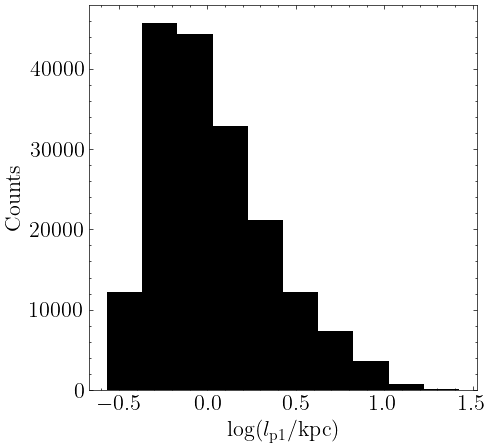

In [264]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l_p1), bins=10)

ax.set_xlabel(r'$\log(l_{\mathrm{p1}}/\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [265]:
get_quantiles(np.log10(l_p1))

-0.03 -0.26 0.41


In [266]:
np.median(np.log10(l_p1))-np.percentile(np.log10(l_p1), 100*(1-cdf_1sig))

0.2586092048356054

In [267]:
np.percentile(np.log10(l_p1), 100*cdf_3sig)

1.144855084819452

Text(0, 0.5, 'Counts')

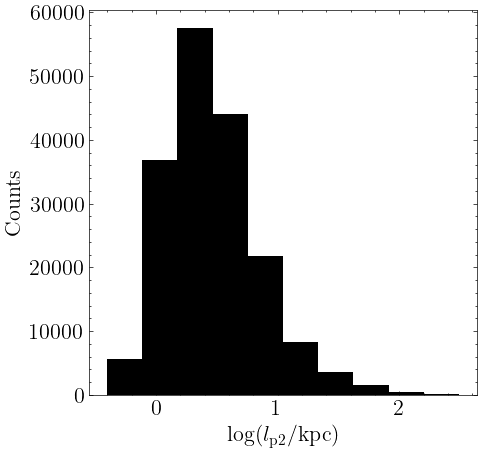

In [268]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l_p2), bins=10)

ax.set_xlabel(r'$\log(l_{\mathrm{p2}}/\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [269]:
get_quantiles(np.log10(l_p2))

0.41 -0.31 0.42


In [278]:
np.percentile(np.log10(l_p2), 100*(1-cdf_3sig)), np.percentile(np.log10(l_p2), 100*cdf_3sig)

(-0.31500235925173886, 2.051042593386059)

In [271]:
np.log10(0.03*(10**-4.1/10**-3)**-1), np.log10(40*(10**-4.1/10**-3)**-0.5)

(-0.422878745280338, 2.1520599913279623)

# DRAFT

# c1 - Single phase solution

In [23]:
gen_logN_ratio_str(logN_dict['OIV'], logN_dict['OIII'])

'0.63, -0.10, 0.10'

In [24]:
logN_ratio_dict = {'OIV/OIII': '0.59, -0.09, 0.09'}
                   #'SIV/OIII': '<-1.2, 0.2',
                   #'SV/OIII': '<-1.5, 0.2'}

(-2.2, 2.5)

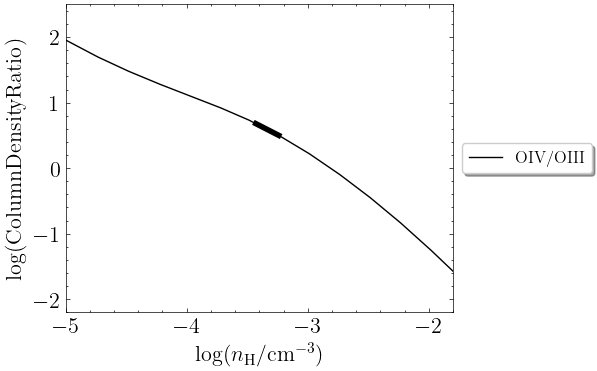

In [25]:
fig, ax = plt.subplots(1, figsize=(5,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict)

ax.set_xlim(-5, -1.8)
ax.set_ylim(-2.2, 2.5)

In [26]:
def log_probability(params, logN_ratio_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    log_hdens = params[0]
    
    lp = log_prior_hdens(log_hdens)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_hdens(log_hdens, logN_ratio_dict, species_logN_interp)

In [27]:
pos = np.array(-3.3) + 1e-4 * np.random.randn(200, 1)
nwalkers, ndim = pos.shape

In [23]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_ratio_dict, species_logN_interp)
)

In [24]:
#sampler.run_mcmc(pos, 500, progress=True);

In [25]:
#flat_samples_hdens = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens'])
#
#flat_samples_hdens.to_csv(savedir+'hdens_op.csv', index=False)

flat_samples_hdens = pd.read_csv(savedir+'hdens_op.csv')

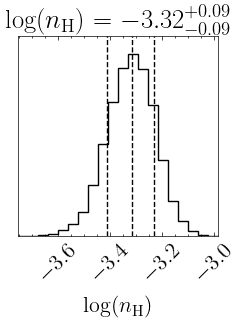

In [26]:
fig = corner.corner(
    flat_samples_hdens, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$', r'$[\mathrm{O/H}]$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [27]:
grid_points_hdens = np.array([[12, log_hdens, -3] for log_hdens in flat_samples_hdens['log_hdens']])

In [28]:
logN_offset = 13.85-np.mean(species_logN_interp['O+2'](grid_points_hdens))

Calculate C/O ratio

In [29]:
logN_CIV_obs = np.random.normal(loc=13.65, scale=0.01, size=len(flat_samples_hdens))

In [30]:
C_O_dist_CIV = logN_CIV_obs-(logN_offset+species_logN_interp['C+3'](grid_points_hdens))
C_O_dist = C_O_dist_CIV

In [31]:
get_quantiles(C_O_dist)

0.0 -0.11 0.11


Calculate the N/O ratio

In [32]:
logN_NIV_obs = np.random.normal(loc=13.1, scale=0.1, size=len(flat_samples_hdens))

In [33]:
N_O_dist_NIV = logN_NIV_obs-(logN_offset+species_logN_interp['N+3'](grid_points_hdens))
N_O_dist = N_O_dist_NIV

In [34]:
get_quantiles(N_O_dist)

-0.5 -0.16 0.16


Get yields

In [35]:
get_quantiles(logN_offset+species_logN_interp['O+2'](grid_points_hdens))

13.85 -0.02 0.01


Plot models

In [36]:
logN_dict = {#'HI':'14.08, -0.06, +0.06',
            'HeI':'<12.7',
            'CII':'<13.1',
            'CIII':'13.0, -0.2, +0.1',
            'CIV':'13.65, -0.01, +0.01',
            'NII':'<13.1',
            'NIII':'<12.8',
            'NIV':'13.1, -0.1, +0.1',
            'OIII':'13.85, -0.08, +0.08',
            'OIV':'14.44, -0.05, +0.05',
            'OV':'14.22, -0.05, +0.05',
            'OVI':'14.64, -0.07, +0.09',
            'NeV':'14.18, -0.05, +0.05',
            'NeVI':'14.21, -0.05, +0.05',
            #'NeVIII':'<13.3',
            #'MgX':'<13.4',
            'AlII':'<10.7',
            'AlIII':'<11.2',
            'SiII':'<13.9',
            'SiIII':'<11.7',
            'SiIV':'<11.7',
            'SIV':'<12.6',
            'SV':'<12.3',
            'SVI':'<12.9'}

In [37]:
sample_indices_hdens = np.random.randint(low=0, high=len(flat_samples_hdens), size=200)

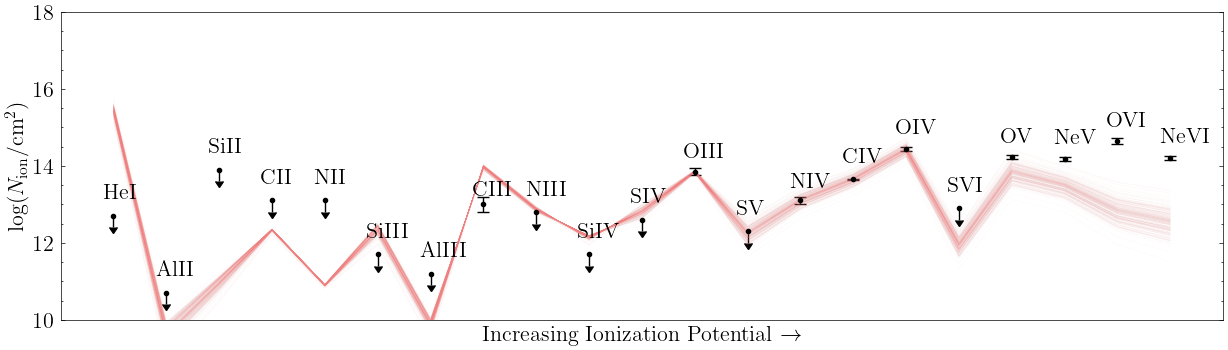

In [38]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_hdens)):
    
    idx = sample_indices_hdens[i]
    flat_samples_row = flat_samples_hdens.iloc[i]
    log_hdens = flat_samples_row['log_hdens']
    
    logN_species_test = predict_col_dens(logN_dict, 12, log_hdens, 
                                         -3, species_logN_interp, {'C': np.median(C_O_dist), 'N': np.median(N_O_dist)})

    # Plot
    ax.plot(np.arange(len(logN_species_test)), 
            np.array(logN_species_test)+logN_offset,
            color='lightcoral', lw=.2, alpha=.1)

# c1 - Density decomposition

In [138]:
def log_probability(params, logN_ratio_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    log_hdens = params[0]
    
    lp = log_prior_hdens(log_hdens)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_hdens(log_hdens, logN_ratio_dict, species_logN_interp)

In [23]:
pos = np.array(-4.3) + 1e-6 * np.random.randn(200, 1)
nwalkers, ndim = pos.shape

In [24]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_ratio_dict, species_logN_interp)
)

In [25]:
#sampler.run_mcmc(pos, 500, progress=True);

In [26]:
#flat_samples_hdens = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens'])

#flat_samples_hdens.to_csv(savedir+'hdens_lo_c1.csv', index=False)

flat_samples_hdens = pd.read_csv(savedir+'hdens_lo_c1.csv')

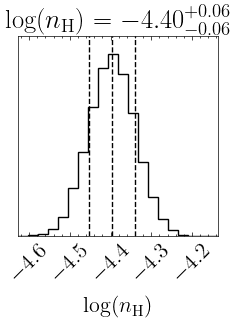

In [27]:
fig = corner.corner(
    flat_samples_hdens, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [28]:
grid_points_hdens = np.array([[12, log_hdens, -3] for log_hdens in flat_samples_hdens['log_hdens']])

In [29]:
hist, bins = np.histogram(species_logN_interp['O+3'](grid_points_hdens), bins=1000)
centers = .5*(bins[1:]+bins[:-1])

Text(0.5, 0, '$\\log N_{\\mathrm{OIV, ref}}$')

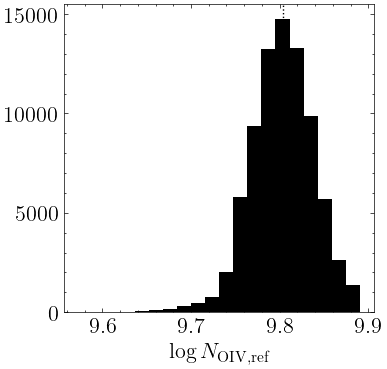

In [30]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(species_logN_interp['O+3'](grid_points_hdens), bins=20)
ax.axvline(np.median(species_logN_interp['O+3'](grid_points_hdens)), linestyle=':')
ax.set_xlabel(r'$\log N_{\mathrm{OIV, ref}}$')

#ax.set_xlim(9.8, 9.9)

Text(0.5, 0, '$\\log N_{\\mathrm{OIII, ref}}$')

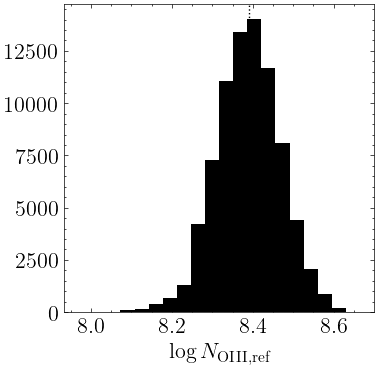

In [31]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(species_logN_interp['O+2'](grid_points_hdens), bins=20)
ax.axvline(np.median(species_logN_interp['O+2'](grid_points_hdens)), linestyle=':')
ax.set_xlabel(r'$\log N_{\mathrm{OIII, ref}}$')

#ax.set_xlim(9.8, 9.9)

Text(0.5, 0, '$\\log N_{\\mathrm{CIII, ref}}$')

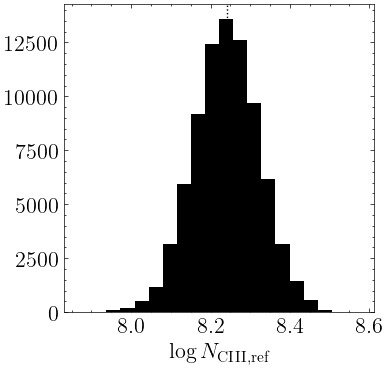

In [32]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(species_logN_interp['C+2'](grid_points_hdens), bins=20)
ax.axvline(np.median(species_logN_interp['C+2'](grid_points_hdens)), linestyle=':')
ax.set_xlabel(r'$\log N_{\mathrm{CIII, ref}}$')

#ax.set_xlim(9.8, 9.9)

Get the offset

In [33]:
logN_offset = 14.45-np.median(species_logN_interp['O+3'](grid_points_hdens))

In [34]:
logN_offset

4.646420697622329

Calculate the C/O ratio

In [35]:
logN_CIV_obs = np.random.normal(loc=13.65, scale=0.01, size=len(flat_samples_hdens))

In [36]:
C_O_dist_CIV = logN_CIV_obs-(logN_offset+species_logN_interp['C+3'](grid_points_hdens))
C_O_dist = C_O_dist_CIV

In [37]:
get_quantiles(C_O_dist)

0.12 -0.03 0.03


Compute N/O ratio

In [38]:
logN_NIV_obs = np.random.normal(loc=13.1, scale=0.1, size=len(flat_samples_hdens))

In [39]:
N_O_dist_NIV = logN_NIV_obs-(logN_offset+species_logN_interp['N+3'](grid_points_hdens))
N_O_dist = N_O_dist_NIV

In [40]:
get_quantiles(N_O_dist)

-0.52 -0.11 0.11


Get yields

In [41]:
get_quantiles(logN_offset+species_logN_interp['O+2'](grid_points_hdens))

13.04 -0.08 0.08


In [42]:
get_quantiles(logN_offset+np.median(C_O_dist)+species_logN_interp['O+2'](grid_points_hdens))

13.16 -0.08 0.08


Plot models

In [43]:
logN_dict = {#'HI':'14.09, -0.06, +0.06',
            #'HeI':'<13.1',
            #'CII':'<13.4',
            'CIII':'12.9, -0.2, +0.1',
            'CIV':'13.65, -0.01, +0.01',
            'NII':'<13.4',
            'NIII':'<13.0',
            'NIV':'13.1, -0.1, +0.1',
            'OIII':'<13.82',
            'OIV':'14.45, -0.05, +0.05',
            'OV':'>14.2',
            'OVI':'14.7, -0.1, +0.1',
            'NeV':'14.17, -0.05, +0.05',
            'NeVI':'14.21, -0.05, +0.05',}
            #'NeVIII':'<13.6',
            #'MgX':'<13.6',
            #'AlII':'<11.0',
            #'AlIII':'<11.4',
            #'SiII':'<14.0',
            #'SiIII':'<11.7',
            #'SiIV':'<12.0',
            #'SIV':'<12.9',
            #'SV':'<12.6',
            #'SVI':'<13.2',}
            #'FeII':'<11.8',}

In [44]:
sample_indices_hdens = np.random.randint(low=0, high=len(flat_samples_hdens), size=200)

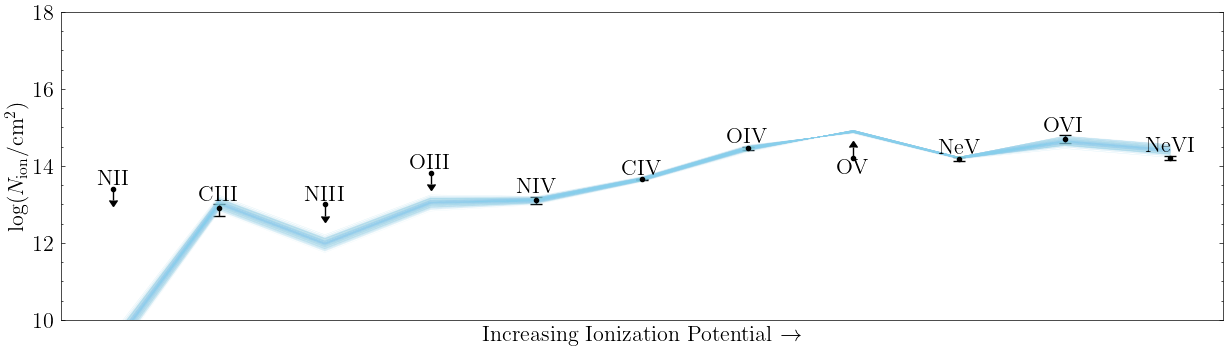

In [45]:
fig, ax = plot_column_densities_obs(logN_dict)

#ax.errorbar(x=1, y=14.06, yerr=[[0.06],[0.04]], color='black', linestyle='None', mfc='white',
#        fmt='o', markersize=3, capsize=4)

#ax.errorbar(x=1, y=13.98, yerr=0.08, color='black', linestyle='None', mfc='white',
#        fmt='o', markersize=3, capsize=4)

for i in range(len(sample_indices_hdens)):
    
    idx = sample_indices_hdens[i]
    flat_samples_row = flat_samples_hdens.iloc[i]
    log_hdens = flat_samples_row['log_hdens']
    
    logN_species_test = predict_col_dens(logN_dict, 12, log_hdens, 
                                         -3, species_logN_interp,
                                        {'C': np.median(C_O_dist), 
                                        'N': np.median(N_O_dist)})

    # Plot
    ax.plot(np.arange(len(logN_species_test)), 
            np.array(logN_species_test)+logN_offset,
            color='skyblue', lw=.2, alpha=.2)

Calculate residual for OIII

In [46]:
logN_OIII_tot = np.random.normal(loc=13.82, scale=0.08, size=1000)
logN_OIII_lo_dens = np.random.normal(loc=13.16, scale=0.08, size=1000)
logN_OIII_hi_dens = np.log10(10**logN_OIII_tot - 10**logN_OIII_lo_dens)

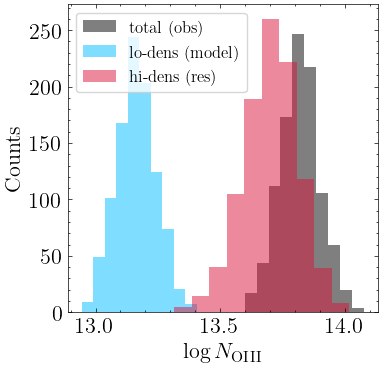

In [47]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(logN_OIII_tot, label='total (obs)', alpha=0.5)
ax.hist(logN_OIII_lo_dens, label='lo-dens (model)', alpha=0.5)
ax.hist(logN_OIII_hi_dens, label='hi-dens (res)', alpha=0.5)

ax.set_xlabel(r'$\log N_{\mathrm{OIII}}$')
ax.set_ylabel('Counts')

#ax.set_xlim(13.81,14.39)
ax.legend(loc='upper left')

In [48]:
logN_OIII_hi_dens_clean = logN_OIII_hi_dens[~np.isnan(logN_OIII_hi_dens)]

In [49]:
get_quantiles(logN_OIII_hi_dens_clean)

13.71 -0.12 0.1


# c1 - Two-phase solution: high density phase

In [50]:
logN_dict = {#'HI':'14.09, -0.06, +0.06',
            #'HeI':'<13.1',
            #'CII':'<13.4',
            #'CIII':'12.9, -0.2, +0.1',
            #'CIV':'13.65, -0.01, +0.01',
            #'NII':'<13.4',
            #'NIII':'<13.0',
            #'NIV':'13.1, -0.1, +0.1',
            'OIII':'13.7, -0.1, +0.1',
            'OIV':'<14.45',
            #'OV':'>14.2',
            #'OVI':'14.7, -0.1, +0.1',
            #'NeV':'14.17, -0.05, +0.05',
            #'NeVI':'14.21, -0.05, +0.05',
            #'NeVIII':'<13.6',
            #'MgX':'<13.6',
            #'AlII':'<11.0',
            #'AlIII':'<11.4',
            'SiII':'<14.0',}
            #'SiIII':'<12.0',
            #'SiIV':'<12.0',
            #'SIV':'<12.9',
            #'SV':'<12.6',
            #'SVI':'<13.2',
            #'FeII':'<11.8',}

In [51]:
gen_logN_ratio_str(logN_dict['OIV'], logN_dict['OIII'])

'<0.75, 0.17'

In [52]:
logN_ratio_dict = {'SiII/OIII': '<0.3, 0.2',
                   'OIV/OIII': '<0.7, 0.2'
                  }

(-5.0, 5.0)

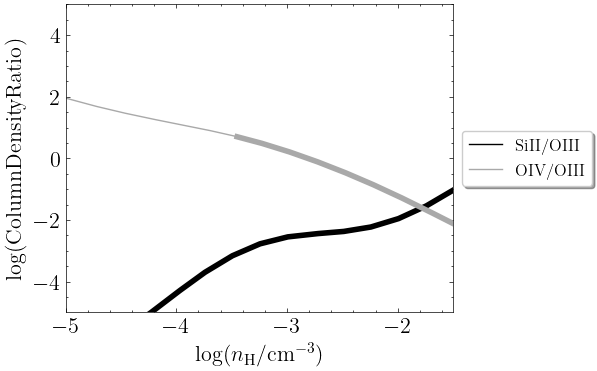

In [53]:
fig, ax = plt.subplots(1, figsize=(5,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict)

ax.set_xlim(-5, -1.5)
ax.set_ylim(-5, 5)

In [54]:
pos = np.array(-2.5) + 1e-6 * np.random.randn(500, 1)
nwalkers, ndim = pos.shape

In [55]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_ratio_dict, species_logN_interp)
)

In [56]:
#sampler.run_mcmc(pos, 500, progress=True);

In [57]:
#flat_samples_hdens = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens'])

#flat_samples_hdens.to_csv(savedir+'hdens_hi_c1.csv', index=False)

flat_samples_hdens = pd.read_csv(savedir+'hdens_hi_c1.csv')

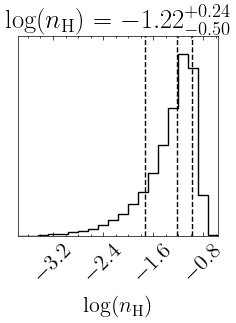

In [58]:
fig = corner.corner(
    flat_samples_hdens, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [59]:
grid_points_hdens = np.array([[12, log_hdens, -3] for log_hdens in flat_samples_hdens['log_hdens']])

In [60]:
logN_offset = 13.7-np.median(species_logN_interp['O+2'](grid_points_hdens))

In [61]:
logN_offset

7.56468093799765

Get yields

Plot models

In [62]:
logN_dict = {#'HI':'14.09, -0.06, +0.06',
            #'HeI':'<13.1',
            #'CII':'<13.4',
            #'CIII':'12.9, -0.2, +0.1',
            #'CIV':'13.65, -0.01, +0.01',
            #'NII':'<13.4',
            #'NIII':'<13.0',
            #'NIV':'13.1, -0.1, +0.1',
            'OIII':'13.7, -0.1, +0.1',
            'OIV':'<14.45',
            #'OV':'>14.2',
            #'OVI':'14.7, -0.1, +0.1',
            #'NeV':'14.17, -0.05, +0.05',
            #'NeVI':'14.21, -0.05, +0.05',
            #'NeVIII':'<13.6',
            #'MgX':'<13.6',
            #'AlII':'<11.0',
            #'AlIII':'<11.4',
            'SiII':'<14.0',
            'SiIII':'<11.7',
            'SiIV':'<12.0',
            'SIV':'<12.9',
            'SV':'<12.6',}
            #'SVI':'<13.2',}
            #'FeII':'<11.8',}

In [63]:
sample_indices_hdens = np.random.randint(low=0, high=len(flat_samples_hdens), size=200)

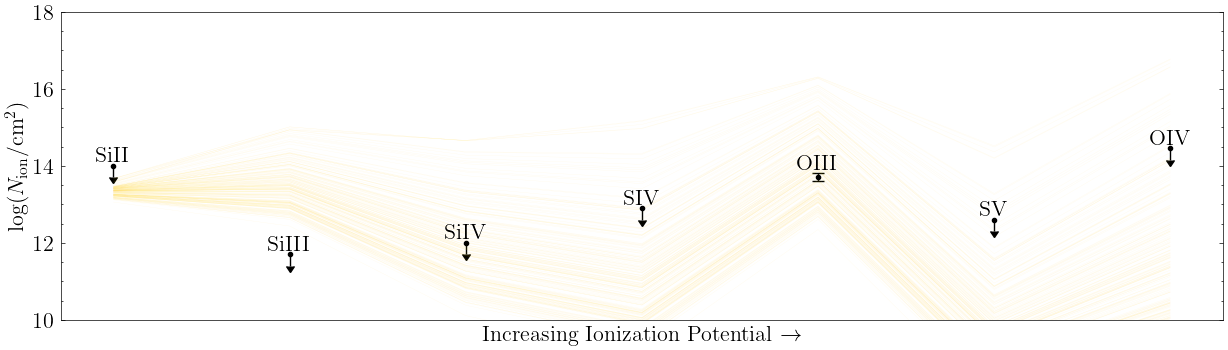

In [64]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_hdens)):
    
    idx = sample_indices_hdens[i]
    flat_samples_row = flat_samples_hdens.iloc[i]
    log_hdens = flat_samples_row['log_hdens']
    
    logN_species_test = predict_col_dens(logN_dict, 12, log_hdens, 
                                         -3, species_logN_interp)

    # Plot
    ax.plot(np.arange(len(logN_species_test)), 
            np.array(logN_species_test)+logN_offset,
            color='gold', lw=.2, alpha=.1)

In [65]:
get_cloud_size(14.09, -1.2, species_logN_interp)

1.9440724316418225e-05

# c1 - Two-phase solution: simultaneous

In [66]:
def lambda_log_prior_two_phase(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {}, logN_HI_p2, log_hdens_p2, log_metals_p2, {}])
    
    return log_prior_two_phase(params_full, species_logN_interp)

In [67]:
def lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {}, logN_HI_p2, log_hdens_p2, log_metals_p2, {}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood_two_phase(params_full, logN_dict, species_logN_interp)    

In [68]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_two_phase(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp)

Fit things

In [69]:
logN_dict = {#'HI':'14.09, -0.06, +0.06',
            #'HeI':'<13.1',
            #'CII':'<13.4',
            #'CIII':'12.9, -0.2, +0.1',
            #'CIV':'13.65, -0.01, +0.01',
            #'NII':'<13.4',
            #'NIII':'<13.0',
            #'NIV':'13.1, -0.1, +0.1',
            'OIII':'13.82, -0.08, +0.08',
            'OIV':'14.45, -0.05, +0.05',
            'OV':'>14.2',
            'OVI':'14.7, -0.1, +0.1',
            #'NeV':'14.17, -0.05, +0.05',
            #'NeVI':'14.21, -0.05, +0.05',
            #'NeVIII':'<13.6',
            #'MgX':'<13.6',
            ##'AlII':'<11.0',
            ##'AlIII':'<11.4',
            'SiII':'<14.0',}
            #'SiIII':'<12.0',
            #'SiIV':'<12.0',
            #'SIV':'<12.9',
            #'SV':'<12.6',
            #'SVI':'<13.2',
            #'FeII':'<11.8',}

In [70]:
logN_HI_test = 14.09
log_hdens_test_p1 = -3.0
log_metals_test_p1 = 0.2

logN_HI_test_p2 = 13.9
log_hdens_test_p2 = -4.3
log_metals_test_p2 = 0.0

In [71]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test, log_hdens_test_p1, log_metals_test_p1, species_logN_interp))
logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, species_logN_interp))
logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

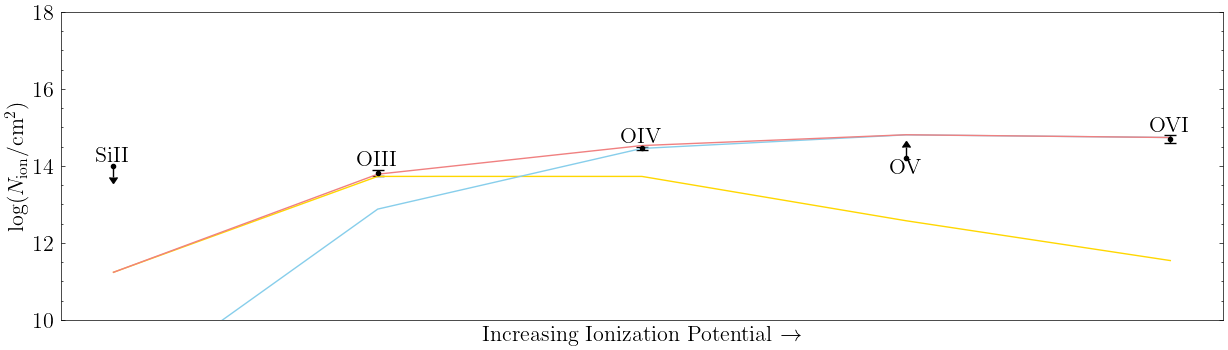

In [72]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='gold')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='skyblue')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [73]:
pos = np.array([log_hdens_test_p1, log_metals_test_p1, 
                logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2]) + 1e-4 * np.random.randn(200, 5)
nwalkers, ndim = pos.shape

In [74]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [75]:
#species_logN_interp['S+5']([16.67, 0.1, -0.6]), species_logN_interp['S+5']([14.9, -2.7, -1.0]), species_logN_interp['S+5']([14.9, -3.7, -1.0])

In [76]:
#sampler.run_mcmc(pos, 500, progress=True);

In [77]:
#flat_samples_two_phase = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens_p1', 'log_metals_p1', 
#                                         'logN_HI_p2', 'log_hdens_p2', 'log_metals_p2'])
#flat_samples_two_phase.to_csv(savedir+'two_phase_c1.csv', index=False)

flat_samples_two_phase = pd.read_csv(savedir+'two_phase_c1.csv')

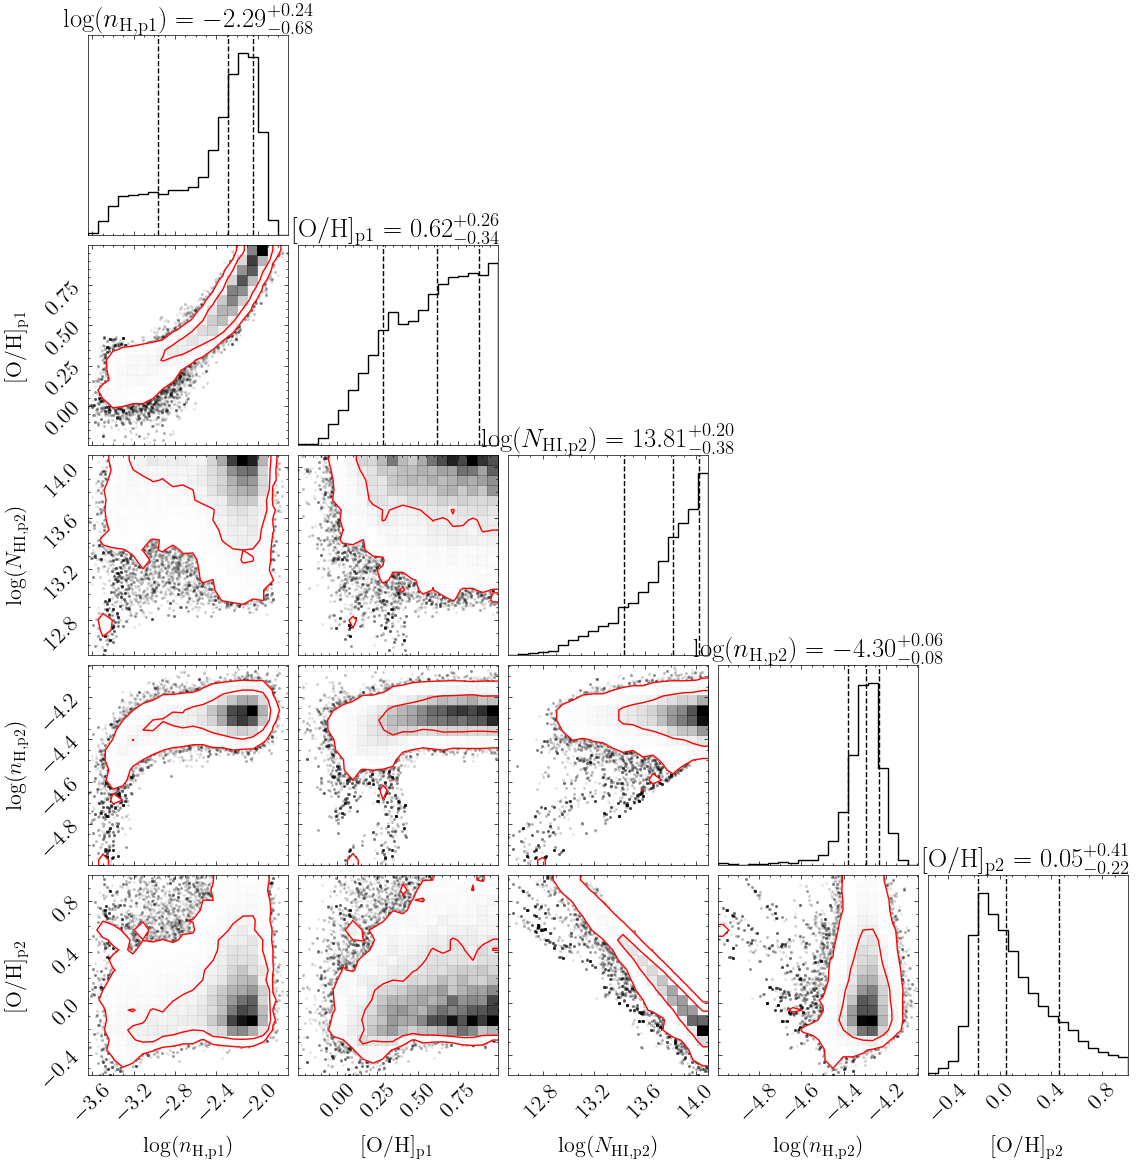

In [78]:
fig = corner.corner(
    flat_samples_two_phase, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H, p1})$', r'$[\mathrm{O/H}]_{\mathrm{p1}}$',
            r'$\log(N_\mathrm{HI, p2})$', r'$\log(n_\mathrm{H, p2})$', r'$[\mathrm{O/H}]_{\mathrm{p2}}$',], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

Now plot the best models

In [79]:
logN_dict = {#'HI':'14.09, -0.06, +0.06',
            #'HeI':'<13.1',
            'CII':'<13.4',
            'CIII':'12.9, -0.2, +0.1',
            'CIV':'13.65, -0.01, +0.01',
            'NII':'<13.4',
            'NIII':'<13.0',
            'NIV':'13.1, -0.1, +0.1',
            'OIII':'13.82, -0.08, +0.08',
            'OIV':'14.45, -0.05, +0.05',
            'OV':'>14.2',
            'OVI':'14.7, -0.1, +0.1',
            'NeV':'14.17, -0.05, +0.05',
            'NeVI':'14.21, -0.05, +0.05',
            #'NeVIII':'<13.6',
            #'MgX':'<13.6',
            ##'AlII':'<11.0',
            ##'AlIII':'<11.4',
            'SiII':'<14.0',}
            #'SiIII':'<11.7',
            #'SiIV':'<12.0',
            #'SIV':'<12.9',
            #'SV':'<12.6',
            #'SVI':'<13.2',
            #'FeII':'<11.8',}

In [80]:
sample_indices_two_phase = np.random.randint(low=0, high=len(flat_samples_two_phase), size=500)

(10.0, 16.0)

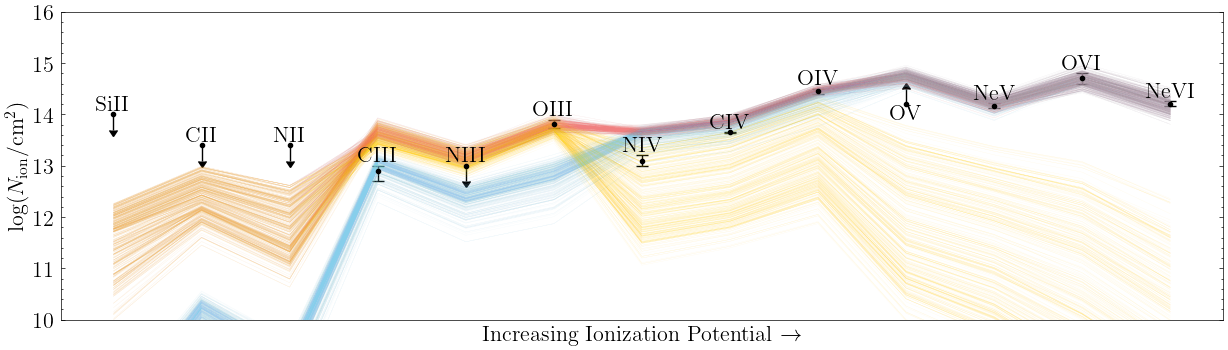

In [81]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_two_phase)):
    
    idx = sample_indices_two_phase[i]
    flat_samples_row = flat_samples_two_phase.iloc[i]
    
    log_hdens_p1 = flat_samples_row['log_hdens_p1']
    log_metals_p1 = flat_samples_row['log_metals_p1']
    
    logN_HI_p2 = flat_samples_row['logN_HI_p2']
    log_hdens_p2 = flat_samples_row['log_hdens_p2']
    log_metals_p2 = flat_samples_row['log_metals_p2']
    
    logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test,  log_hdens_p1, log_metals_p1, species_logN_interp))
    logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_p2,  log_hdens_p2, log_metals_p2, species_logN_interp))

    logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

    # Plot
    ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='gold', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='skyblue', lw=.2, alpha=.1)
    
ax.set_ylim(10,16)

# c2 - Two-phase solution: low density phase

In [137]:
logN_dict = {#'HI':'13.99, -0.07, +0.07',
        #'HeI':'<13.1',
        #'CII':'<13.4',
        #'CIII':'<12.7',
        #'CIV':'13.41, -0.01, +0.01',
        #'NII':'<13.4',
        #'NIII':'<13.0',
        #'NIV':'<12.7',
        'OIII':'<13.4',
        'OIV':'14.22, -0.06, +0.06',
        'OV':'>14.2',
        'OVI':'14.0, -0.1, +0.1',}
        #'NeV':'13.7, -0.1, +0.1',
        #'NeVI':'13.97, -0.08, +0.08',
        #'NeVIII':'<13.6',
        #'MgX':'<13.6',
        #'AlII':'<11.0',
        #'AlIII':'<11.4',
        #'SiII':'<14.0',
        #'SiIII':'<12.0',
        #'SiIV':'<12.0',
        #'SIV':'<12.9',
        #'SV':'<12.6',
        #'SVI':'<13.2',
        #'FeII':'<11.8'}

Get column density ratios

In [140]:
gen_logN_ratio_str(logN_dict['OIII'], logN_dict['OIV'])

'<-0.82, 0.15'

In [141]:
logN_ratio_dict = {'OVI/OIV':'-0.2, -0.1, 0.1',
                   'OV/OIV': '>-0.0, 0.3',
                   'OIII/OIV':'<-0.8, 0.2'}

(-2.2, 2.0)

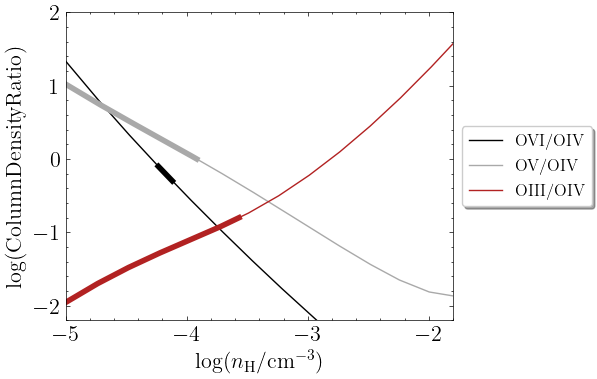

In [142]:
fig, ax = plt.subplots(1, figsize=(5,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict)

ax.set_xlim(-5, -1.8)
ax.set_ylim(-2.2, 2)

In [146]:
def log_probability(params, logN_ratio_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    log_hdens = params[0]
    
    lp = log_prior_hdens(log_hdens)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_hdens(log_hdens, logN_ratio_dict, species_logN_interp)

In [147]:
pos = np.array(-4.2) + 1e-6 * np.random.randn(500, 1)
nwalkers, ndim = pos.shape

In [148]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_ratio_dict, species_logN_interp)
)

In [151]:
#sampler.run_mcmc(pos, 500, progress=True);

In [154]:
#flat_samples_hdens = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens'])

#flat_samples_hdens.to_csv(savedir+'hdens_lo_c2.csv', index=False)

flat_samples_hdens = pd.read_csv(savedir+'hdens_lo_c2.csv')

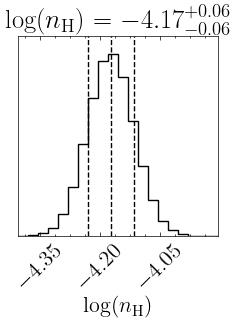

In [155]:
fig = corner.corner(
    flat_samples_hdens, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [156]:
grid_points_hdens = np.array([[12, log_hdens, -3] for log_hdens in flat_samples_hdens['log_hdens']])

In [157]:
hist, bins = np.histogram(species_logN_interp['O+3'](grid_points_hdens), bins=1000)
centers = .5*(bins[1:]+bins[:-1])

Text(0.5, 0, '$\\log N_{\\mathrm{OIV, ref}}$')

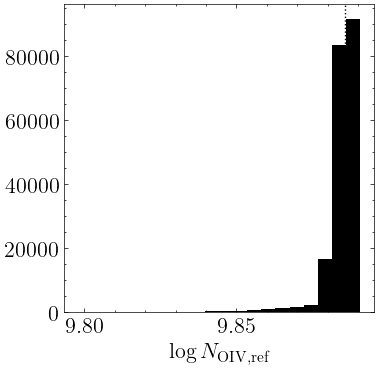

In [158]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(species_logN_interp['O+3'](grid_points_hdens), bins=20)
ax.axvline(np.median(species_logN_interp['O+3'](grid_points_hdens)), linestyle=':')
ax.set_xlabel(r'$\log N_{\mathrm{OIV, ref}}$')

#ax.set_xlim(9.8, 9.9)

Get the offset

In [159]:
logN_offset = 14.22-np.median(species_logN_interp['O+3'](grid_points_hdens))

In [160]:
logN_offset

4.334373130311752

Calculate the C/O ratio

In [161]:
logN_CIV_obs = np.random.normal(loc=13.41, scale=0.01, size=len(flat_samples_hdens))

In [162]:
C_O_dist_CIV = logN_CIV_obs-(logN_offset+species_logN_interp['C+3'](grid_points_hdens))
C_O_dist = C_O_dist_CIV

In [163]:
get_quantiles(C_O_dist)

0.12 -0.01 0.01


Plot models

In [164]:
logN_dict = {#'HI':'13.99, -0.07, +0.07',
        #'HeI':'<13.1',
        #'CII':'<13.4',
        'CIII':'<12.7',
        'CIV':'13.41, -0.01, +0.01',
        #'NII':'<13.4',
        #'NIII':'<13.0',
        #'NIV':'<12.7',
        'OIII':'<13.4',
        'OIV':'14.22, -0.06, +0.06',
        'OV':'>14.2',
        'OVI':'14.0, -0.1, +0.1',
        'NeV':'13.7, -0.1, +0.1',
        'NeVI':'13.97, -0.08, +0.08',
        #'NeVIII':'<13.6',
        #'MgX':'<13.6',
        #'AlII':'<11.0',
        #'AlIII':'<11.4',
        'SiII':'<14.0',}
        #'SiIII':'<11.7',
        #'SiIV':'<12.0',
        #'SIV':'<12.9',
        #'SV':'<12.6',
        #'SVI':'<13.2',
        #'FeII':'<11.8'}

In [165]:
sample_indices_hdens = np.random.randint(low=0, high=len(flat_samples_hdens), size=200)

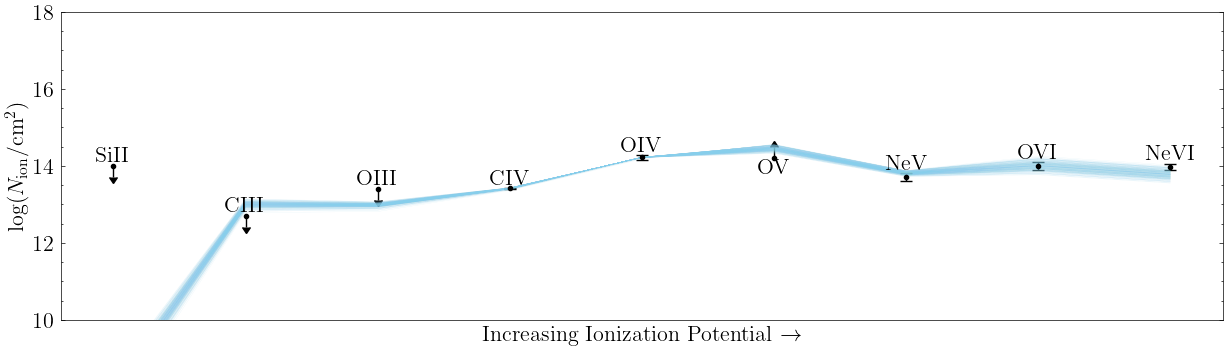

In [166]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_hdens)):
    
    idx = sample_indices_hdens[i]
    flat_samples_row = flat_samples_hdens.iloc[i]
    log_hdens = flat_samples_row['log_hdens']
    
    logN_species_test = predict_col_dens(logN_dict, 12, log_hdens, 
                                         -3, species_logN_interp,
                                        {'C':np.median(C_O_dist)})

    # Plot
    ax.plot(np.arange(len(logN_species_test)), 
            np.array(logN_species_test)+logN_offset,
            color='skyblue', lw=.2, alpha=.2)

In [34]:
logN_species_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples['log_hdens'], flat_samples['log_metals'], 
                                                 species_logN_interp, {'C':flat_samples['C_O'], 'N':flat_samples['N_O']})

logN_species_med = np.median(logN_species_grid, axis=1)
logN_species_lo = np.percentile(logN_species_grid, 100*(1-cdf_1sig), axis=1)
logN_species_hi = np.percentile(logN_species_grid, 100*cdf_1sig, axis=1)

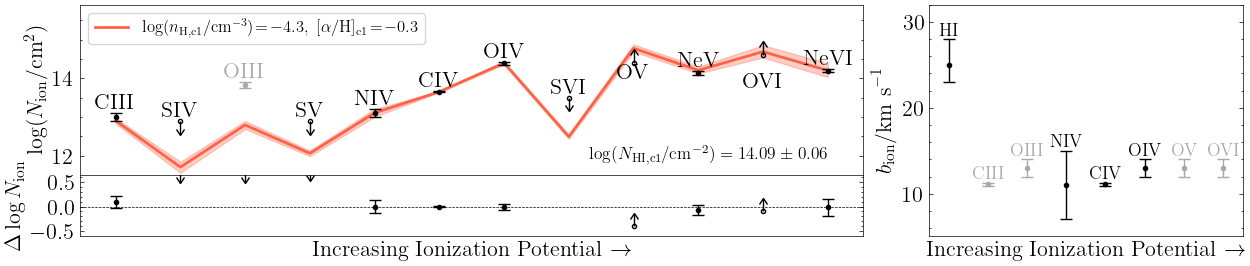

In [39]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

axd['upper left'].fill_between(np.arange(len(logN_dict)), logN_species_lo, logN_species_hi,
                color='tomato', alpha=.3)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_med, color='tomato', lw=2, alpha=1)

    
plot_column_densities_obs(logN_dict, fig, axd['upper left'], gray_out=['OIII'], c_dy=1.7)

axd['upper left'].set_ylim(11.5,15.9)

axd['upper left'].text(len(logN_dict)-1, 11.9, r'$\log(N_\mathrm{HI, c1}/\mathrm{cm}^{-2}) = 14.09 \pm 0.06$', fontsize=12.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c1}/\mathrm{cm}^{-3}) \!=\! -4.3, \ \mathrm{[\alpha/H]_{c1}} \!=\! -0.3$'))

axd['upper left'].legend(handles=handles, loc='upper left', fontsize=12)

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'],
                          label_ions=False, dy=.15, c_dy=1.7)

plot_column_densities_obs(logN_res_up, fig, axd['lower left'], 
                          label_ions=False, dy=.15, c_dy=1.7)

axd['lower left'].set_ylim(-.6,.65)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_linewidth_obs(b_dict, fig, axd['right'], fs=13, gray_out=['CIII', 'OIII', 'OV', 'OVI'])
axd['right'].set_xlim(-0.5,len(b_dict)-1+.5)
axd['right'].set_ylim(5.1,32)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

In [64]:
logN_species_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples['log_hdens'], flat_samples['log_metals'], 
                                                 species_logN_interp, {'C':flat_samples['C_O'], 'N':flat_samples['N_O']})

logN_species_med = np.median(logN_species_grid, axis=1)
logN_species_lo = np.percentile(logN_species_grid, 100*(1-cdf_1sig), axis=1)
logN_species_hi = np.percentile(logN_species_grid, 100*cdf_1sig, axis=1)

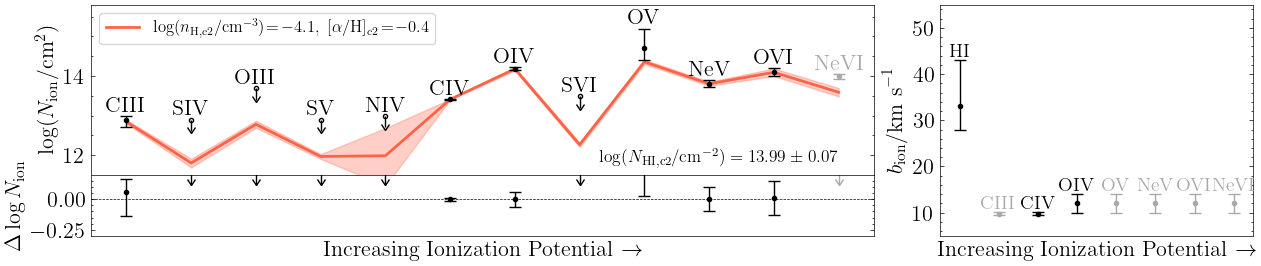

In [64]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

axd['upper left'].fill_between(np.arange(len(logN_dict)), logN_species_lo, logN_species_hi,
                color='tomato', alpha=.3)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_med, color='tomato', lw=2, alpha=1)

    
plot_column_densities_obs(logN_dict, fig, axd['upper left'], gray_out=['NeVI'])

axd['upper left'].set_ylim(11.5,15.8)

axd['upper left'].text(len(logN_dict)-1, 11.8, r'$\log(N_\mathrm{HI, c2}/\mathrm{cm}^{-2}) = 13.99 \pm 0.07$', fontsize=12.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c2}/\mathrm{cm}^{-3}) \!=\! -4.1, \ \mathrm{[\alpha/H]_{c2}} \!=\! -0.4$'))

axd['upper left'].legend(handles=handles, loc='upper left', fontsize=12)

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'],
                          gray_out = ['NeVI'], label_ions=False, dy=.1)
plot_column_densities_obs(logN_res_up, fig, axd['lower left'],
                          gray_out = ['NeVI'], label_ions=False, dy=.1)

axd['lower left'].set_ylim(-0.3,0.2)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'], fs=14, gray_out=['CIII','OV','NeV','OVI','NeVI'])
axd['right'].set_xlim(-0.5, len(b_dict)-1+0.5)
axd['right'].set_ylim(5,55)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_cloudy_c2_op.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)